# 2023-2 인공지능 최종 프로젝트

과목 : 인공지능

교수님 : 이수안 교수님


학번 : 2021218034 이름 : 서세일

주제

구글(GOOG) 주식 예측을 위한 시계열 예측 모델 비교

목적

다양한 시계열 예측 모델의 성능을 비교하여 구글 주식 예측에 적합한 모델을 도출

방법

1. 야후 파이낸스에 있는 과거데이터를 가져온다.(12년 1월~ 23년 12월)
2. 5가지(ARIMA, Prophet, Transformer, NeuralProphet) 시계열 예측 모델을 확인해본다.
3. 예측 모델 5가지 확인 후 성능지표 (MAE, RMSE, MAPE) 추출
4. 성능지표를 통해 가장 적합한 모델을 지정


## 사용 라이브러리 정리

In [ ]:
# 데이터셋 불러오기
import yfinance as yf # 주식 가격 데이터를 Yahoo Finance에서 가져오는 라이브러리
import datetime # 날짜와 시간 python 모듈
import matplotlib.pyplot as plt # 데이터 시각화 라이브러리

In [ ]:
# ARIMA 및 필요기능들 설치
!pip install pmdarima -q # 아리마 모델을 사용하기 위한 라이브러리
!pip install exchange_calendars -q # 거래소의 시간 정보를 다루기 위해 설치(휴장일, 거래시간 등)

In [ ]:
# ARIMA Import
# 통계분석 라이브러리 import
from statsmodels.tsa.stattools import adfuller # 시계열 데이터 정상성 평가
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # 자기상관함수 시각화 (전체구조,부분구조)
from statsmodels.tsa.arima_model import ARIMA # ARIMA 모델생성 클래스, 정의 및 피팅

# ARIMA 모델관련 기능 제공 라이브러리
import pmdarima as pm # ARIMA 모델 및 관련기능 제공
from pmdarima.arima import ndiffs # 시계열 데이터에 대한 차분 수행 (정상성 확보, 최적의 차분횟수 반환)

# 사이킷런 라이브러리 사용 (성능점수 확인용)
from sklearn.metrics import mean_squared_error, mean_absolute_error # 평균 제곱 오차(MSE), 평균 절대 오차(MAE)

# 기타 추가 라이브러리
import exchange_calendars as ecals # 영업일, 거래시간, 휴장일 정보 처리
import math # 수학 계산 처리

# 데이터 처리 라이브러리
import pandas as pd # 데이터 조작 및 분석, 데이터프레임
import numpy as np # 과학 및 수학 연산 라이브러리, 다차원 배열, 함수

In [ ]:
# Prophet Import (중복되는 라이브러리나 함수는 생략)
from sklearn.preprocessing import MinMaxScaler # 데이터 min max 정규화
from prophet import Prophet # 프로펫 모델 임포트, fbprophet에서 prophet으로 바뀜

In [ ]:
# Transformer import
import keras # 케라스 라이브러리
from keras import layers # 딥러닝 레이어 제공

In [ ]:
# Neural Prophet 설치
!pip install prophet -q # 프로펫 설치
!pip install fpdf -q
!pip install neuralprophet -q # 뉴럴 프로펫 설치

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
neuralprophet 0.6.2 requires holidays<0.22,>=0.21, but you have holidays 0.38 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.1.5 requires holidays>=0.25, but you have holidays 0.21.13 which is incompatible.


In [ ]:
# Neural Prophet import
from neuralprophet import NeuralProphet, set_log_level # 뉴럴 프로펫 클래스, 로그레벨 지정 함수
set_log_level("ERROR") # 로그레벨을 ERROR로 설정
import plotly.express as px # 시각화 라이브러리

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
# LSTM Import
from tensorflow.keras.models import Sequential # 숫차 모델 정의 클래스
from tensorflow.keras.layers import Dense, Dropout, LSTM # 레이어 클래스, 완전연결, 과적합 방지, 장단기 레이어

import seaborn as sns # 시각화 라이브러리
from sklearn.metrics import r2_score # 결정 계수 계산
import random as ran # 랜덤 모듈

## 사용 데이터셋
야후 파이낸스의 구글 주가 누적데이터를 불러와서 사용


데이터의 이동을 하는 것이 아닌 라이브러리를 이용한 데이터셋 가져오기 진행

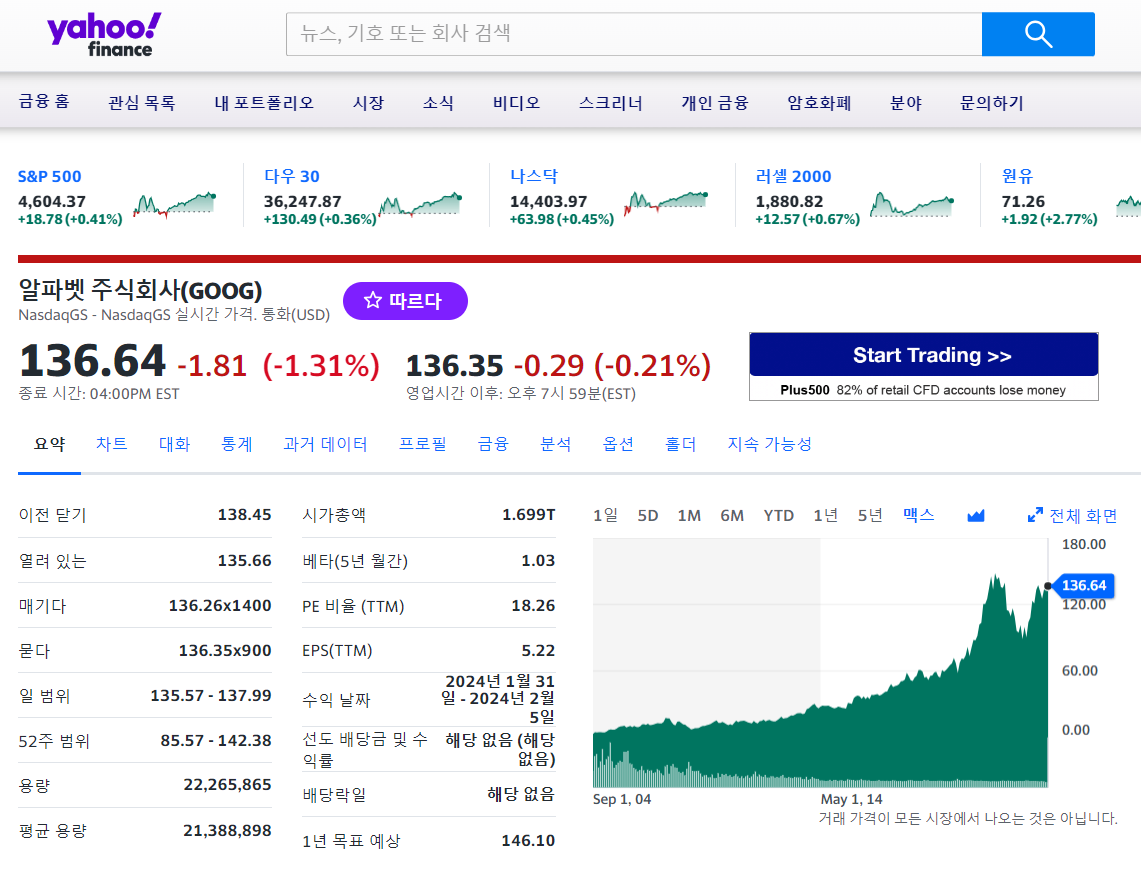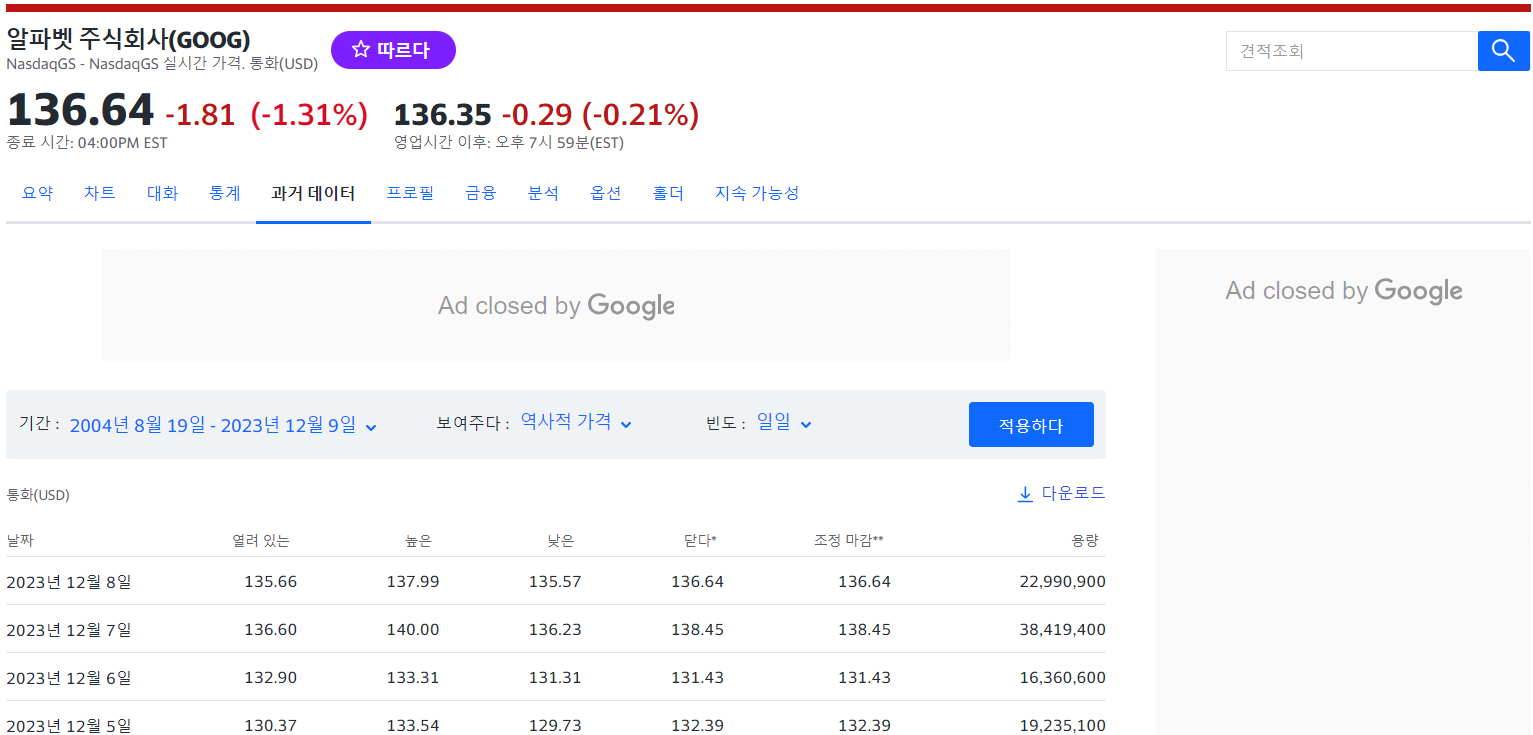

In [ ]:
symbol = "GOOG"  # 주식 심볼 (Google의 경우 "GOOG"를 사용)
start_date = datetime.datetime(2012, 1, 1)  # 시작 날짜
end_date = datetime.datetime(2023, 12, 3)   # 종료 날짜
alphabet = yf.download(symbol, start=start_date, end=end_date)

print("<Alphabet Inc. (GOOG) 주가 Historical Data>\n")
print(alphabet)

[*********************100%%**********************]  1 of 1 completed
<Alphabet Inc. (GOOG) 주가 Historical Data>

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2012-01-03   16.262545   16.641375   16.248346   16.573130   16.573130   
2012-01-04   16.563665   16.693678   16.453827   16.644611   16.644611   
2012-01-05   16.491436   16.537264   16.344486   16.413727   16.413727   
2012-01-06   16.417213   16.438385   16.184088   16.189817   16.189817   
2012-01-09   16.102144   16.114599   15.472754   15.503389   15.503389   
...                ...         ...         ...         ...         ...   
2023-11-27  137.570007  139.630005  137.539993  138.050003  138.050003   
2023-11-28  137.630005  138.660004  137.039993  138.619995  138.619995   
2023-11-29  138.985001  139.669998  136.294998  136.399994  136.399994   
2023-11-30  136.399994  136.960007  132.789993  133.919998  133.919998   


##ARIMA 모델 사용 주가예측

### 데이터셋 가공

In [ ]:
# 거래량이 0인 일자 제거 & 수정종가 데이터만 사용
data = alphabet['Adj Close'][alphabet['Volume'] != 0]

### 평균이동 계산

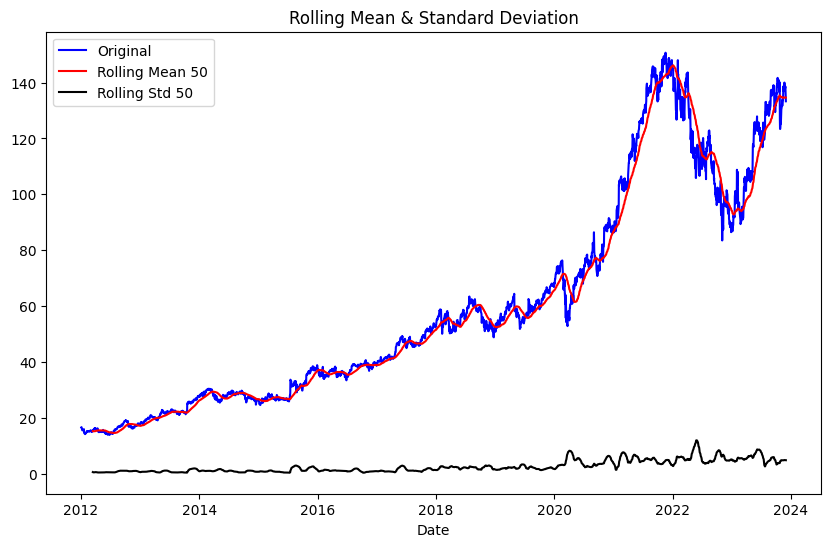

In [ ]:
def plot_rolling(data, interval):
  # interva :  시계열 데이터의 이동편균 계산 구간
    # 인터벌 크기의 이동 평균을 계산
    rolmean = data.rolling(interval).mean()
    # 인터벌 크기의 이동 표준편차 계산
    rolstd = data.rolling(interval).std()
    # 시각화
    plt.figure(figsize=(10, 6))
    plt.xlabel('Date')
    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean {}'.format(interval))
    std = plt.plot(rolstd, color='black', label = 'Rolling Std {}'.format(interval))
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

# 50일치 평균내어 이동평균계산
plot_rolling(data, 50)

### 정상성 여부 확인 및 차분 분석 수행

In [ ]:
# FDA 검정 수행
# 시계열 데이터의 정상성 여부 판단, 정상성을 가지면 안정적 통계적 속성 획득
def adf_test(data):
    result = adfuller(data.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('num of lags: %f' % result[2])
    print('num of observations: %f' % result[3])
    print('Critical values:')
    for k, v in result[4].items():
        print('\t%s: %.3f' % (k,v))

print('ADF TEST 결과')
adf_test(data)
#  통계량 0.17, p값 0.97, 임계값 전부 음수
# p-value 가 0.05 보다 크므로 정상성을 가지고 있지 않음

ADF TEST 결과
ADF Statistics: 0.172304
p-value: 0.970665
num of lags: 23.000000
num of observations: 2975.000000
Critical values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


<Axes: xlabel='Date'>

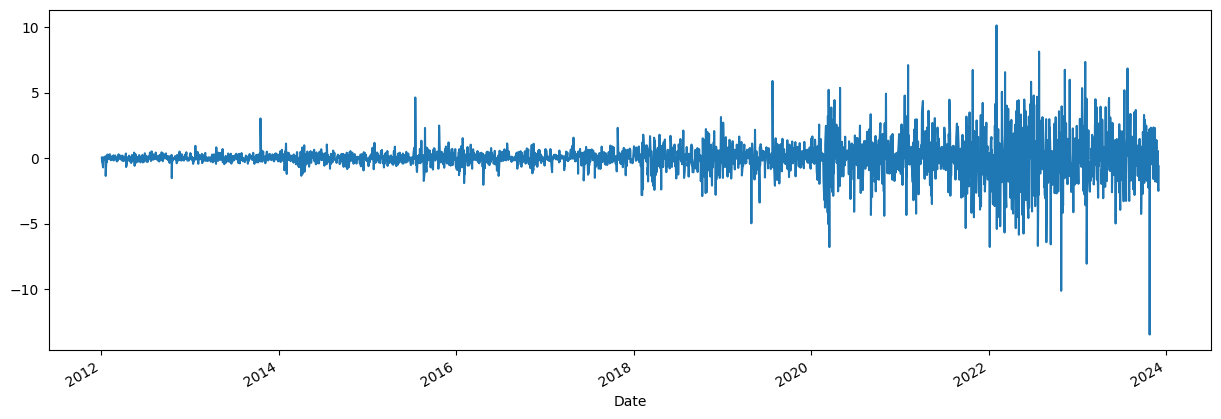

In [ ]:
# 1차 차분 데이터 수행
dff1 = data.diff().dropna()
dff1.plot(figsize=(15,5))

In [ ]:
# 차분 테이터 adf테스트
print('ADF TEST 결과')
adf_test(dff1)
# 통계량 -11.14, p값 0, 임계값 -3.4, -2.9, -2.6
# p-value가 0.05보다 작으므로 정상성을 가지고 있음

ADF TEST 결과
ADF Statistics: -11.142184
p-value: 0.000000
num of lags: 29.000000
num of observations: 2968.000000
Critical values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


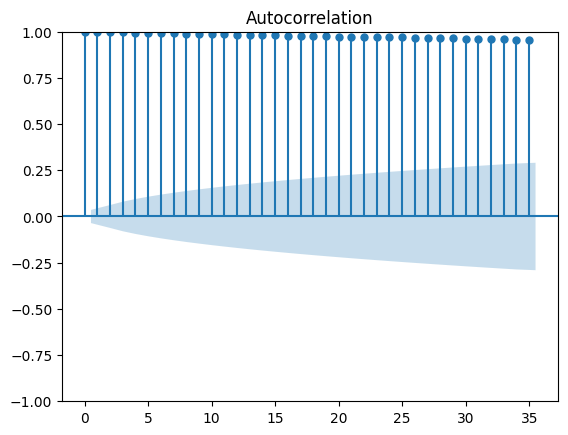

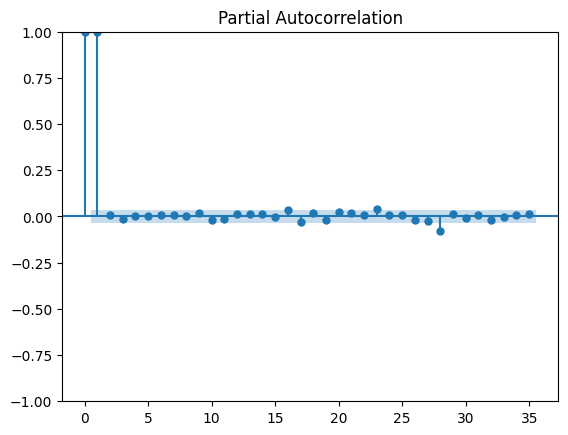

In [ ]:
plot_acf(data) # ACF 계산 및 시각화
plot_pacf(data) # 1전 과거, 현재 시점간 자기 상관관계(지연시간 제외), PACF 계산 및 시각화
plt.show()

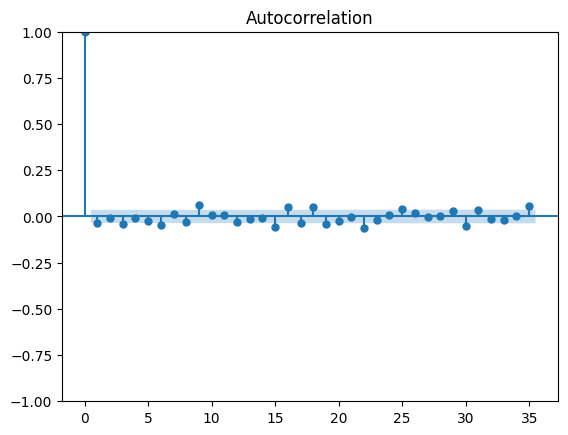

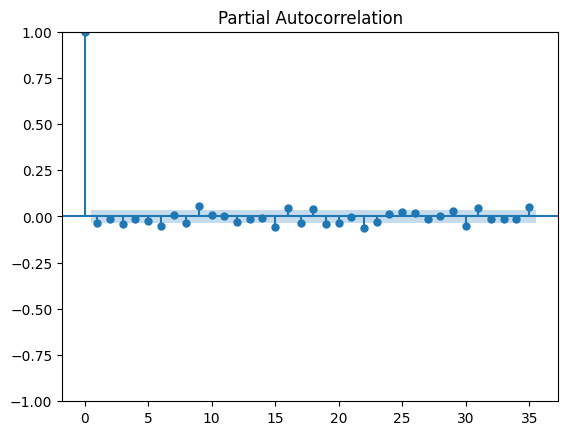

In [ ]:
# 1차 차분한 데이터를 같은 방식으로 계산
plot_acf(dff1)
plot_pacf(dff1)
plt.show()

In [ ]:
# 차분차수 추정
n_diffs = ndiffs(data, alpha=0.05, test='adf', max_d=6)
n_diffs = ndiffs(data, alpha=0.05, test='adf', max_d=6)
print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


### 모델 설정 및 생성

In [ ]:
# 모델 자동 설정 및 생성
model = pm.auto_arima(
            y=data,
            d=1, # 차분 차수 1 지정
            start_p=0, max_p=3,
            start_q=0, max_q=3,
            m=1, seasonal=False, # 계절성이 없다고 지정
            stepwise=True,
            # trace=True 각 단계별 로그출력 및 과정 추적
)

In [ ]:
# 모델 정보 출력
model.summary()
# auto_arima를 통해 가장 최적의 모델을 확인

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2999
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -5101.096
Date:                Mon, 11 Dec 2023   AIC                          10210.192
Time:                        19:00:58   BIC                          10234.215
Sample:                             0   HQIC                         10218.833
                               - 2999                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0058      0.003      1.692      0.091      -0.001       0.012
ar.L1          0.8535      0.040     21.494      0.000       0.776       0.931
ma.L1         -0.8879      0.035    -25.167      0.000      -0.957      -0.819
sigma2         1.7597      0.018     99.430      0.000       1.725       1.794
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             16376.20
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):              31.02   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 모델 진단 및 학습 진행

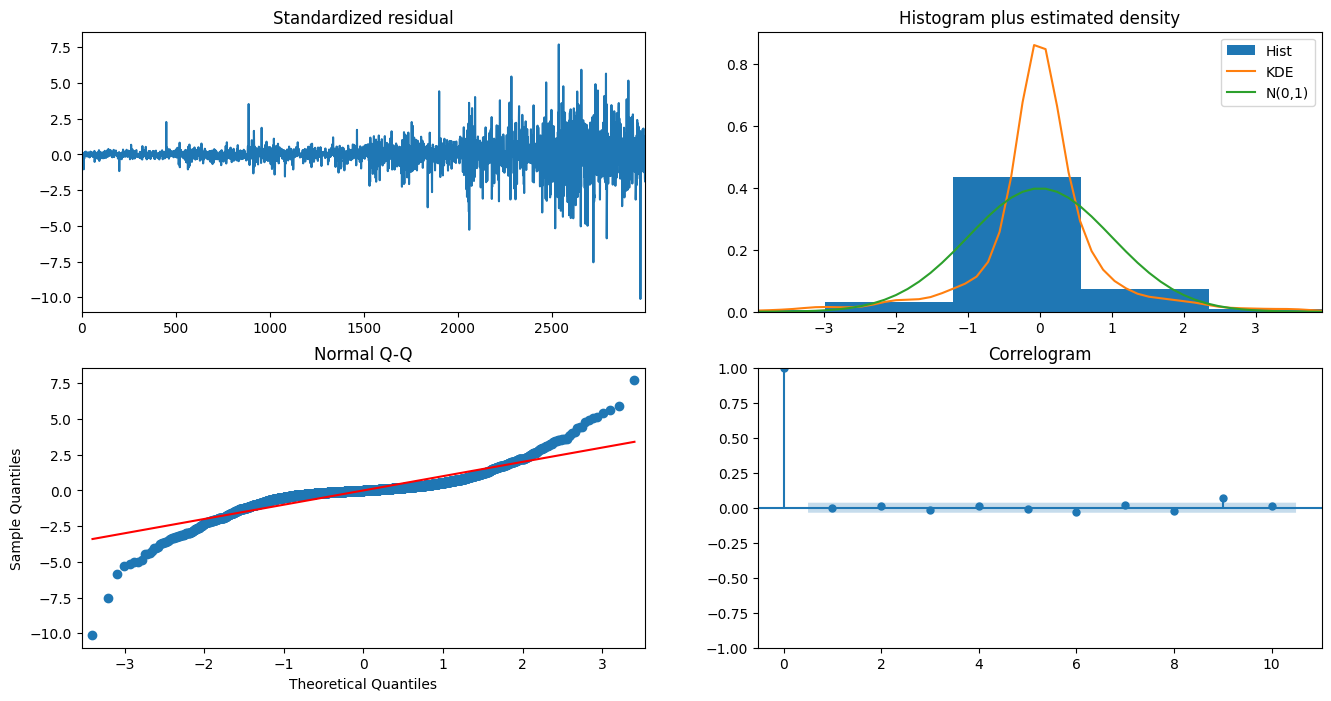

In [ ]:
# ARIMA 모델의 진단 그래픽을 출력
model.plot_diagnostics(figsize=(16,8))
plt.show()

In [ ]:
# 훈련데이터와 테스트데이터 분할
train_data, test_data = data[:int(len(data)*0.9)], data[int(len(data)*0.9):]

In [ ]:
# auto_arima를 사용하여 자동으로 설정하고 훈련 진행
model_fit = pm.auto_arima(
    	    y=train_data,
 	        d=n_diffs ,
            start_p=0, max_p=2,
            start_q=0, max_q=2,
            m=1, seasonal=False,
            stepwise=True,
            trace=True
)
model_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8503.043, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8492.301, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8492.831, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8502.956, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8492.842, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8490.616, Time=1.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8492.572, Time=2.93 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8492.562, Time=3.89 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8493.683, Time=1.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8489.161, Time=4.71 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=8489.980, Time=1.88 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 17.050 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2699
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -4238.580
Date:                Mon, 11 Dec 2023   AIC                           8489.161
Time:                        19:01:16   BIC                           8524.562
Sample:                             0   HQIC                          8501.963
                               - 2699                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0099      0.008      1.236      0.216      -0.006       0.026
ar.L1          0.2360      0.155      1.522      0.128      -0.068       0.540
ar.L2          0.4481      0.093      4.830      0.000       0.266       0.630
ma.L1         -0.3161      0.158     -2.007      0.045      -0.625      -0.007
ma.L2         -0.4227      0.099     -4.276      0.000      -0.617      -0.229
sigma2         1.3554      0.015     91.519      0.000       1.326       1.384
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):             12473.47
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):              27.86   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Forecast 진행 및 성능 점수 확인

In [ ]:
# forecast 함수
def forecast_n_step(model, n = 1):
    fc, conf_int = model.predict(n_periods=n, return_conf_int=True)
    # print("fc", fc,"conf_int", conf_int)
    return (
        fc.tolist()[0:n], np.asarray(conf_int).tolist()[0:n]
   )

def forecast(len, model, index, data=None):
    y_pred = []
    pred_upper = []
    pred_lower = []

    if data is not None:
        for new_ob in data:
            fc, conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(new_ob)
    else:
        for i in range(len):
            fc, conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(fc[0])
    return pd.Series(y_pred, index=index), pred_upper, pred_lower

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(

  return get_prediction_index(

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(

  return get_prediction_index(



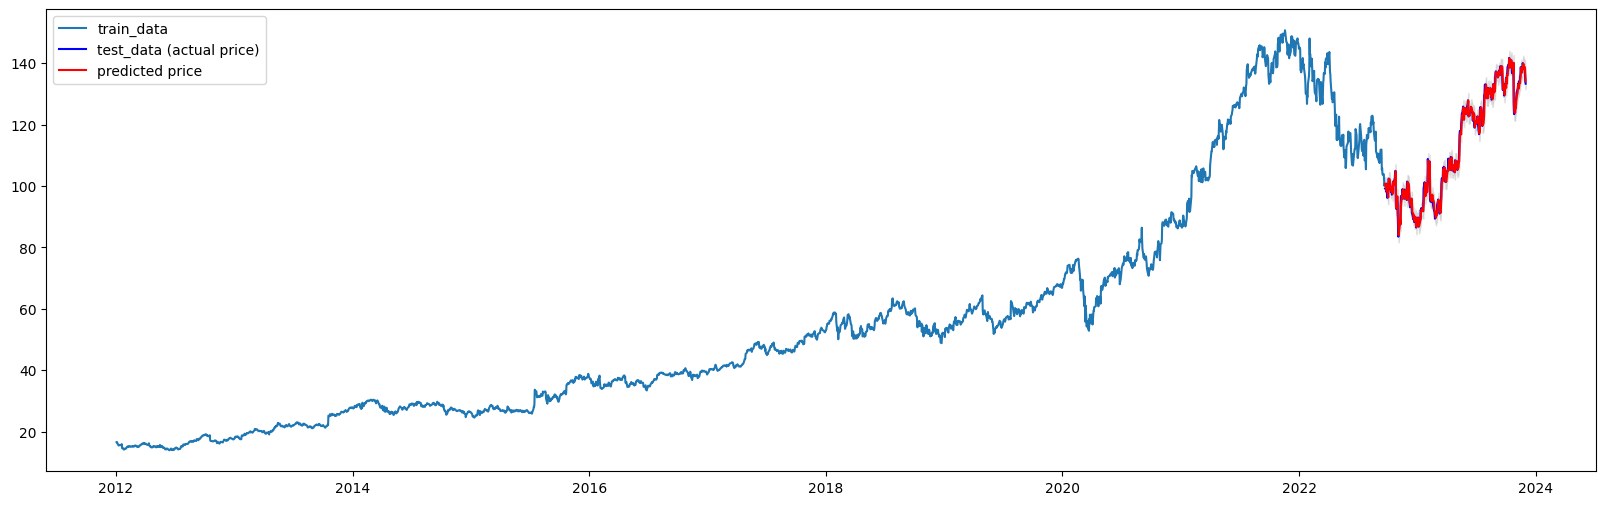

In [ ]:
# Forecast
fc, upper, lower = forecast(len(test_data), model_fit, test_data.index, data = test_data)

# pandas series 생성
# fc # 예측결과
lower_series = pd.Series(lower, index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(upper, index=test_data.index)  # 예측결과의 상한 바운드

# 시각화
plt.figure(figsize=(20,6))
plt.plot(train_data, label='train_data')
plt.plot(test_data, c='b', label='test_data (actual price)')
plt.plot(fc, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend(loc='upper left')
plt.show()

In [ ]:
# 성능평가 점수 출력
amse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', amse)
amae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', amae)
armse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', armse)
amape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: ' ,'{:.2f}%'.format(amape*100))

MSE:  6.57054323094734e+120
MAE:  4.513391348914797e+59
RMSE:  2.5633070886936936e+60
MAPE:  233803.66%


### 성능지표 데이터 저장

In [ ]:
# 마지막에 비교할 성능지표 표에 저장
# 모델명, MSE, RMSE, MAPE 값을 저장할 리스트 생성
performance_data = []


# 모델명 추가
performance_data.append('Arima')
# 각 성능 지표 추가
performance_data.append(amse)
performance_data.append(amae)
performance_data.append(armse)
performance_data.append(amape)

# 리스트를 행으로 갖는 데이터프레임 생성
performance_df = pd.DataFrame([performance_data], columns=['Model', 'MSE', 'MAE', 'RMSE', 'MAPE'])

# 데이터프레임 출력
print(performance_df)

   Model            MSE           MAE          RMSE         MAPE
0  Arima  6.570543e+120  4.513391e+59  2.563307e+60  2338.036585


### 미래 주가 예상 진행 (추가 코드 확인)

In [ ]:
# 미래주가 예상
def get_open_dates(start,end):
    k = ecals.get_calendar("XKRX")
    df = pd.DataFrame(k.schedule.loc[start:end]) #["2022-11-01":"2023-10-31"])
    # print(df['open'])
    date_list = []
    for i in df['open']:
        date_list.append(i.strftime("%Y-%m-%d"))
       # print(i.strftime("%Y-%m-%d"))
    date_index = pd.DatetimeIndex(date_list)
    return date_index  # DatetimeIndex

1년 후 주가
2024-11-26    143.479261
2024-11-27    143.518458
2024-11-28    143.557610
2024-11-29    143.596873
2024-12-02    143.636146
dtype: float64


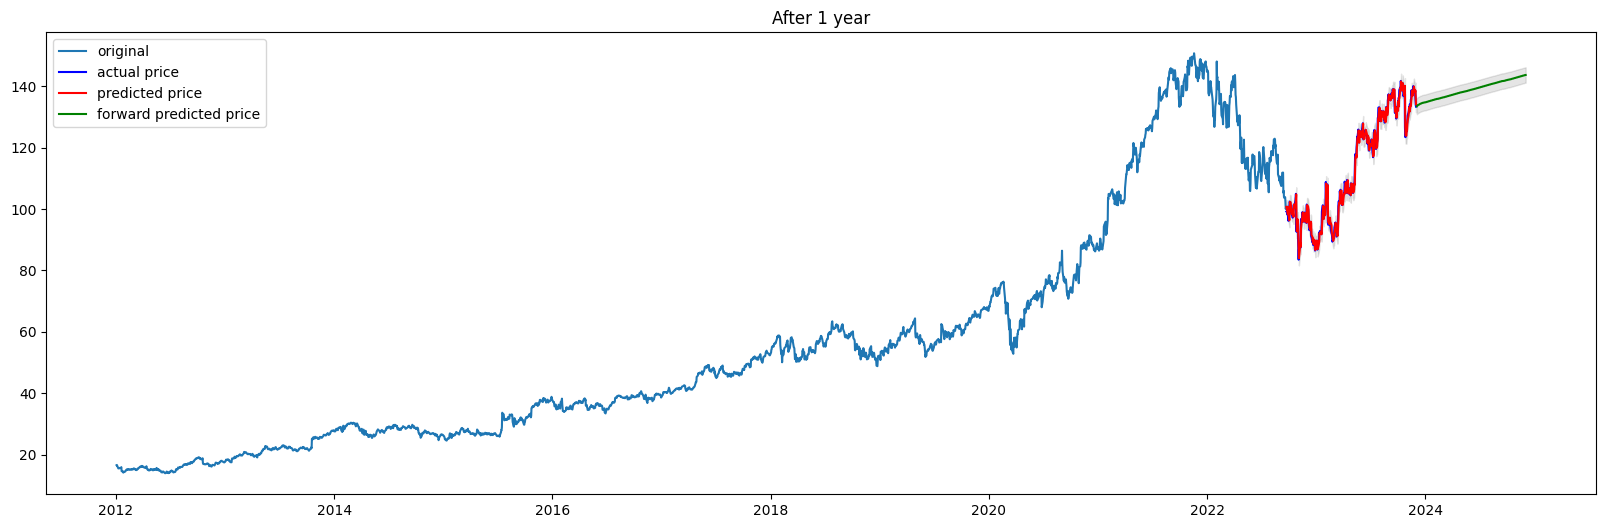

In [ ]:
date_index = get_open_dates("2023-12-03","2024-12-2")
fc2, upper2, lower2 = forecast(len(date_index), model_fit, date_index)
print('1년 후 주가')
print(fc2.tail())

lower_series2 = pd.Series(lower2, index=date_index)  # 예측결과의 하한 바운드
upper_series2 = pd.Series(upper2, index=date_index)  # 예측결과의 상한 바운드

# 시각화
plt.figure(figsize=(20,6))
plt.plot(train_data, label='original')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc, c='r',label='predicted price')
plt.plot(fc2, c='g',label='forward predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.10)
plt.title('After 1 year')
plt.legend(loc='upper left')
plt.show()

##Prophet 모델 사용 주가예측

### 테이터 셋 가공

In [ ]:
# 데이터 불러오기
alphabet = yf.download(symbol, start=start_date, end=end_date)
print("<Alphabet Inc. (GOOG) 주가 Historical Data>\n")
print(alphabet)

[*********************100%%**********************]  1 of 1 completed
<Alphabet Inc. (GOOG) 주가 Historical Data>

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2012-01-03   16.262545   16.641375   16.248346   16.573130   16.573130   
2012-01-04   16.563665   16.693678   16.453827   16.644611   16.644611   
2012-01-05   16.491436   16.537264   16.344486   16.413727   16.413727   
2012-01-06   16.417213   16.438385   16.184088   16.189817   16.189817   
2012-01-09   16.102144   16.114599   15.472754   15.503389   15.503389   
...                ...         ...         ...         ...         ...   
2023-11-27  137.570007  139.630005  137.539993  138.050003  138.050003   
2023-11-28  137.630005  138.660004  137.039993  138.619995  138.619995   
2023-11-29  138.985001  139.669998  136.294998  136.399994  136.399994   
2023-11-30  136.399994  136.960007  132.789993  133.919998  133.919998   


In [ ]:
# 데이터 프레임으로 변경
df = alphabet
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,16.262545,16.641375,16.248346,16.573130,16.573130,147611217
2012-01-04,16.563665,16.693678,16.453827,16.644611,16.644611,114989399
2012-01-05,16.491436,16.537264,16.344486,16.413727,16.413727,131808205
2012-01-06,16.417213,16.438385,16.184088,16.189817,16.189817,108119746
2012-01-09,16.102144,16.114599,15.472754,15.503389,15.503389,233776981
...,...,...,...,...,...,...
2023-11-27,137.570007,139.630005,137.539993,138.050003,138.050003,17886400
2023-11-28,137.630005,138.660004,137.039993,138.619995,138.619995,17046900
2023-11-29,138.985001,139.669998,136.294998,136.399994,136.399994,21014700


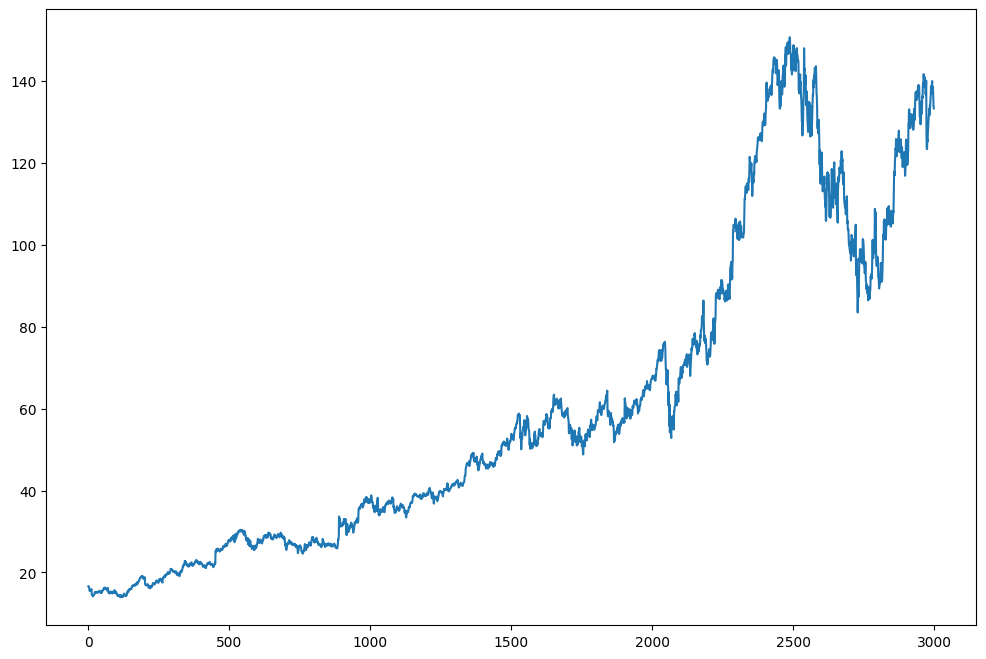

In [ ]:
# 데이터 프레임의 Close(종가)를 기준으로 출력
data = df['Close'].values

plt.figure(figsize=(12, 8))
plt.plot(data)
plt.show()

In [ ]:
# 표준화 진행
data = np.array(data).reshape(-1,1)    # 표준화를 하기 위해 사이즈를 (-1,1)로 조정
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)
scaled

array([[0.01936668],
       [0.01988927],
       [0.01820133],
       ...,
       [0.89539049],
       [0.87725987],
       [0.87287349]])

In [ ]:
# 테스트 데이터 분할
test_idx = int(len(scaled) * 0.8)

train = scaled[:test_idx]
test = scaled[test_idx:]

In [ ]:
# 데이터 칼럼을 새로 만들어 시간과 종가를 기준으로 지정
df['ds'] = pd.to_datetime(df.index)
df['y'] = df['Close']

In [ ]:
df[['ds', 'y']].iloc[:-10]

,ds,y
Date,,
2012-01-03,2012-01-03,16.573130
2012-01-04,2012-01-04,16.644611
2012-01-05,2012-01-05,16.413727
2012-01-06,2012-01-06,16.189817
2012-01-09,2012-01-09,15.503389
...,...,...
2023-11-10,2023-11-10,134.059998
2023-11-13,2023-11-13,133.639999
2023-11-14,2023-11-14,135.429993


### 기본모델 생성 및 학습과 분석

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxht9avo4/akfyao0c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxht9avo4/hbwbp1an.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98013', 'data', 'file=/tmp/tmpxht9avo4/akfyao0c.json', 'init=/tmp/tmpxht9avo4/hbwbp1an.json', 'output', 'file=/tmp/tmpxht9avo4/prophet_modelfmmnhdkq/prophet_model-20231211190705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


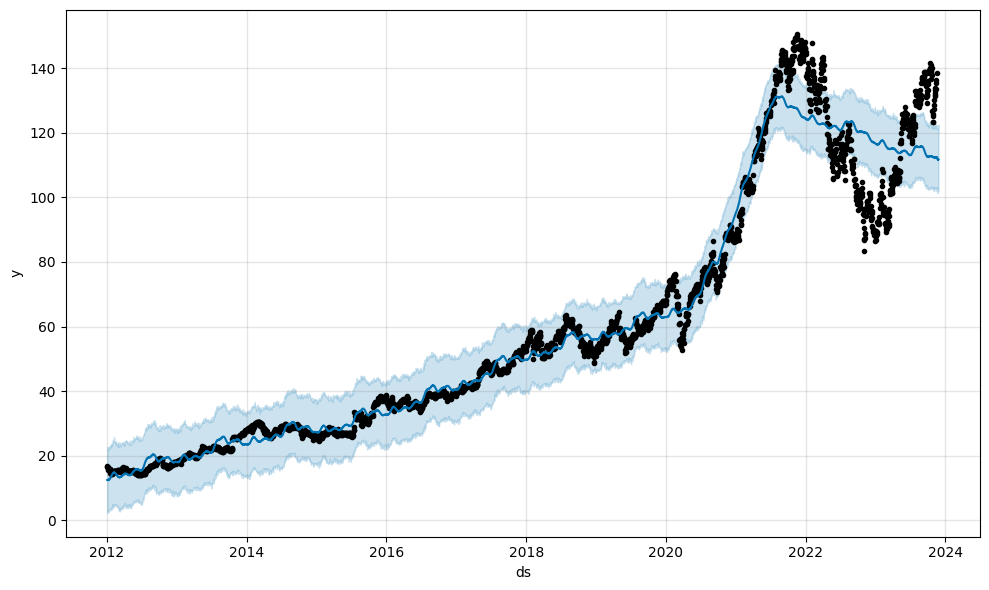

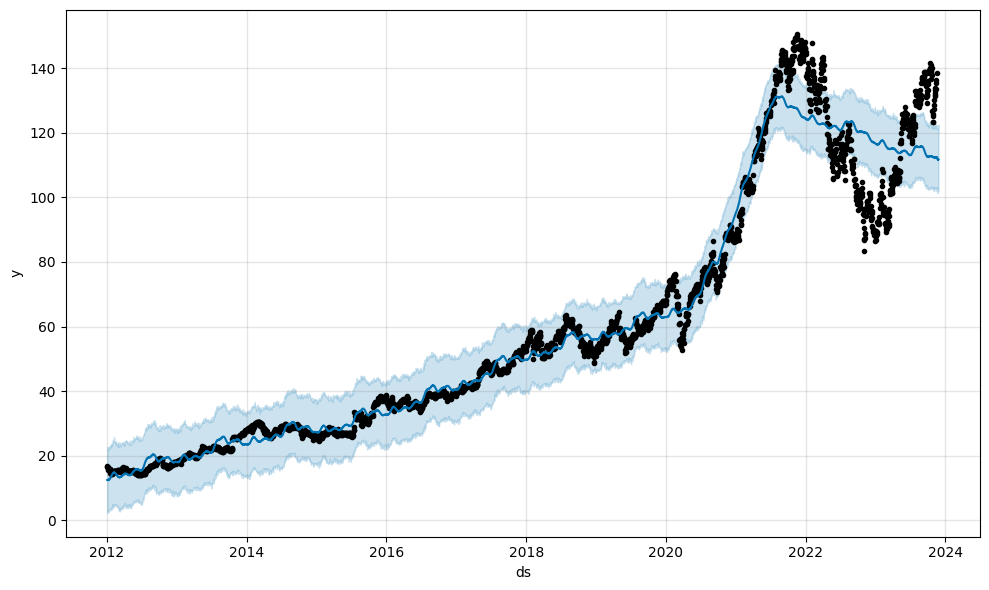

In [ ]:
# Day 단위로 데이터가 구성되어 있으므로, 일 단위 주기성 활성화
model = Prophet(daily_seasonality=True)

# 데이터 학습 시작 -> 기계학습
model.fit(df[['ds', 'y']].iloc[:-10])

# 주가 예측 위한 날짜 데이터 세팅 -> 기존 데이터 + 향후 10일치 예측값
future = model.make_future_dataframe(periods=10)

# 주가 예측
forecast = model.predict(future)

# forecast.columns ->
'''
  Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')
'''

# 필요한 컬럼만 보기
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(11)

# 모델이 제공하는 시각화
model.plot(forecast)

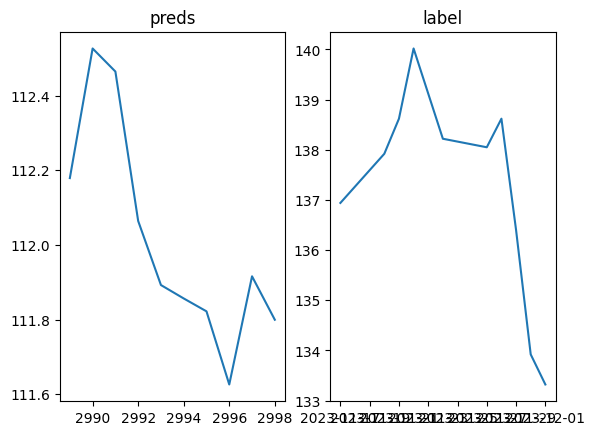

In [ ]:
# 예측값과 실주가 데이터를 비교해서 확인 (좌:예측값, 우:실주가데이터)
plt.subplot(1,2,1)
plt.plot(forecast.tail(10)['yhat'])
plt.title('preds')
plt.subplot(1,2,2)
plt.title('label')
plt.plot(df.tail(10)['Close'])
plt.show()

### 여러가지 주기성 성분 변동 시각화 확인

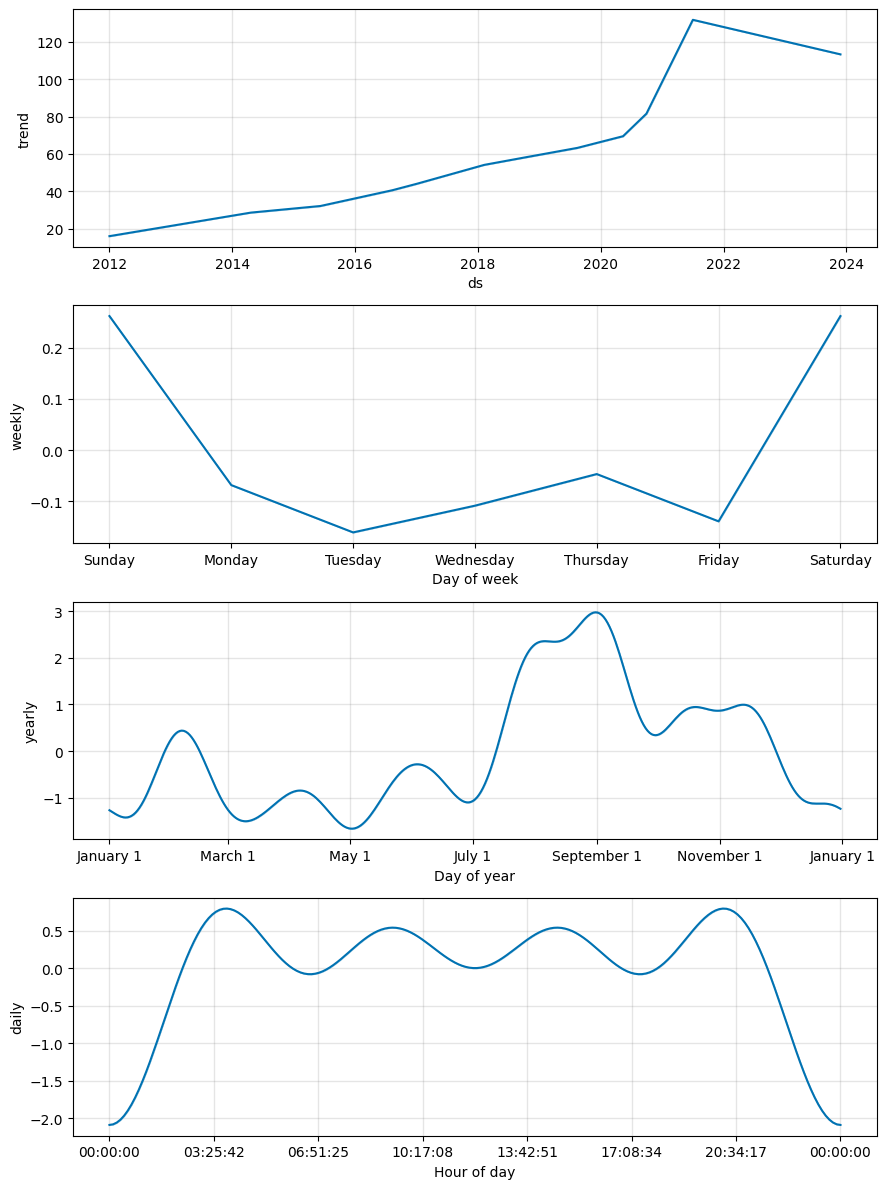

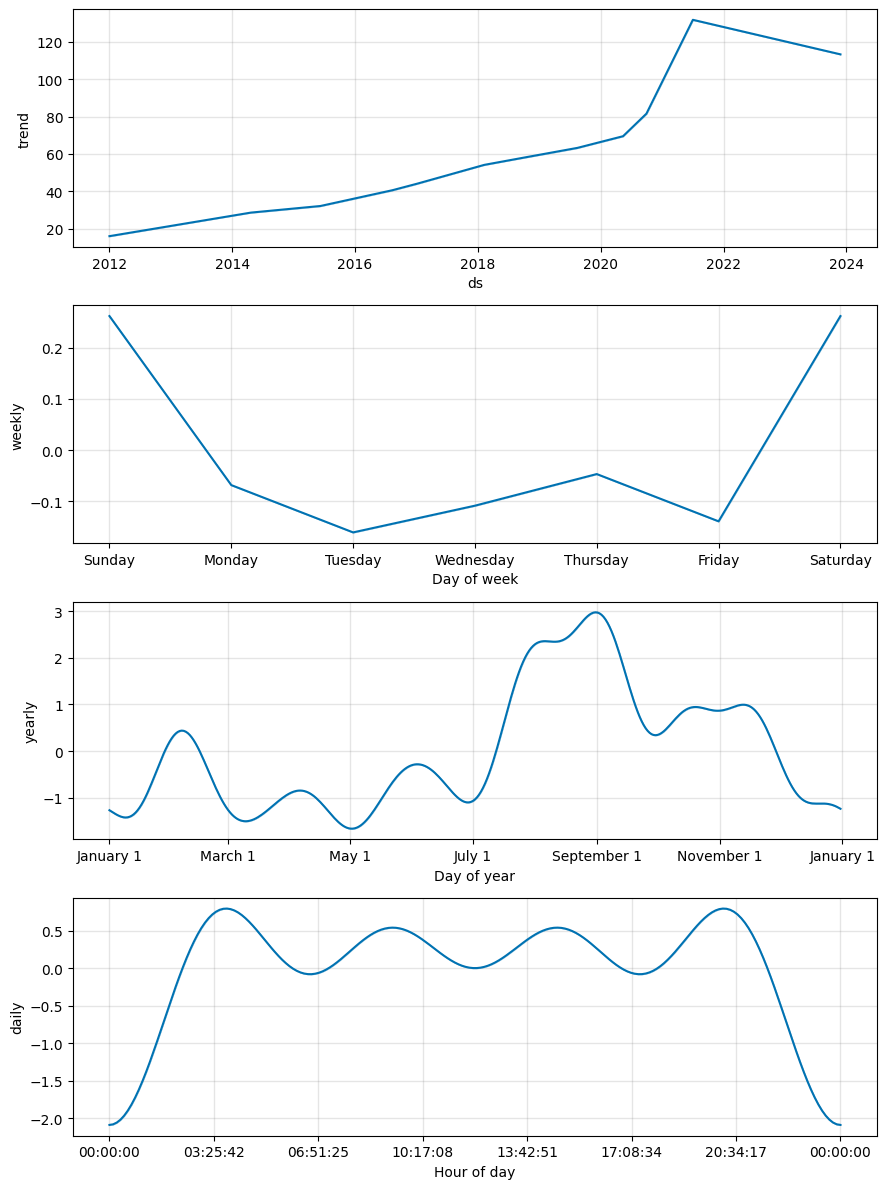

In [ ]:
model.plot_components(forecast)
# 트렌드, 주간, 월간, 년간 주기성 확인

In [ ]:
# 칼럼확인
print(df.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'ds', 'y'], dtype='object')


In [ ]:
# 변동율 계산 값 칼럼 생성
df['Change'] = (df['Close'] - df['Open']) / df['Open']
print(df)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2012-01-03   16.262545   16.641375   16.248346   16.573130   16.573130   
2012-01-04   16.563665   16.693678   16.453827   16.644611   16.644611   
2012-01-05   16.491436   16.537264   16.344486   16.413727   16.413727   
2012-01-06   16.417213   16.438385   16.184088   16.189817   16.189817   
2012-01-09   16.102144   16.114599   15.472754   15.503389   15.503389   
...                ...         ...         ...         ...         ...   
2023-11-27  137.570007  139.630005  137.539993  138.050003  138.050003   
2023-11-28  137.630005  138.660004  137.039993  138.619995  138.619995   
2023-11-29  138.985001  139.669998  136.294998  136.399994  136.399994   
2023-11-30  136.399994  136.960007  132.789993  133.919998  133.919998   
2023-12-01  133.320007  133.500000  132.151993  133.320007  133.320007   

               Volume         ds     

### 새로운 모델 생성 및 타겟 재설정

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxht9avo4/kmbtnjzn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxht9avo4/sao3z3cr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67192', 'data', 'file=/tmp/tmpxht9avo4/kmbtnjzn.json', 'init=/tmp/tmpxht9avo4/sao3z3cr.json', 'output', 'file=/tmp/tmpxht9avo4/prophet_modelihk1scvm/prophet_model-20231211190711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


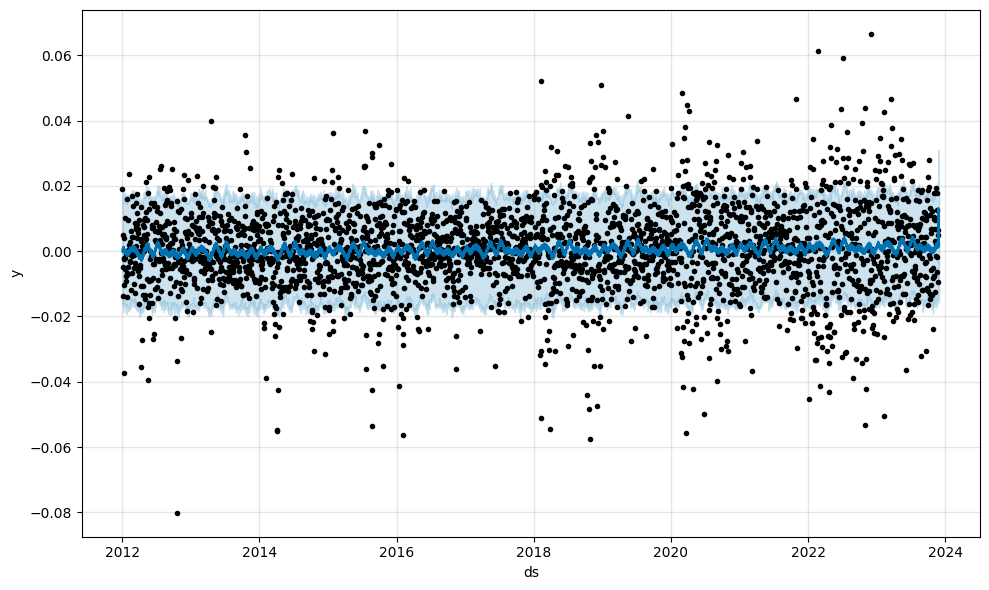

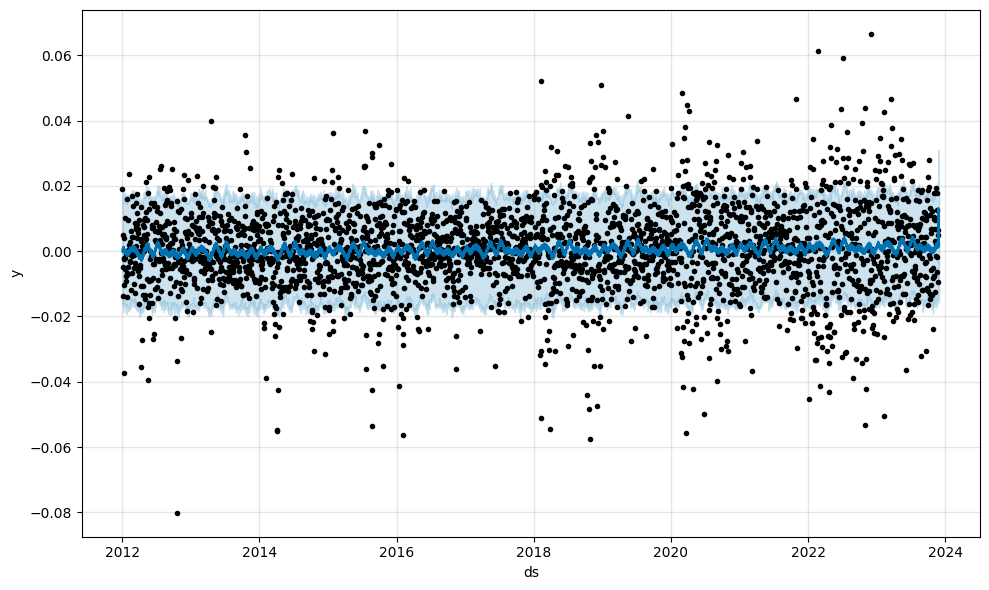

In [ ]:
model = Prophet()

df['y'] = df['Change']
# 데이터 학습 시작 -> 기계학습
model.fit(df[['ds', 'y']].iloc[:-5])

# 주가 예측 위한 날짜 데이터 세팅 -> 기존 데이터 + 향후 5일치 예측값
future = model.make_future_dataframe(periods=5)

forecast = model.predict(future)

target_changes = forecast['yhat'].tail(11)

# 모델이 제공하는 시각화
model.plot(forecast)

### 주가 변동율 평균을 통한 분석 진행

In [ ]:
target_mean_change = round(target_changes.mean(),4)
target_mean_change = 1 - abs(target_mean_change)
target_mean_change

0.9961

In [ ]:
# 종가에 주가변동률 평균의 제곱을 곱합
preds = []

preds.append(df.iloc[-1]['Close'] * target_mean_change)
preds.append(df.iloc[-1]['Close'] * target_mean_change * target_mean_change)
preds.append(df.iloc[-1]['Close'] * target_mean_change * target_mean_change * target_mean_change)
preds.append(df.iloc[-1]['Close'] * target_mean_change * target_mean_change * target_mean_change * target_mean_change)

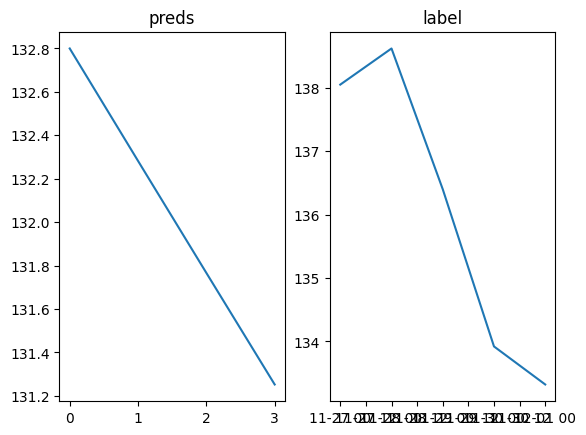

In [ ]:
plt.subplot(1,2,1)
plt.title('preds')
plt.plot(preds)
plt.subplot(1,2,2)
plt.title('label')
plt.plot(df.tail(5)['Close'])
plt.show()

### 성능지표 데이터 저장

In [ ]:
pmse = mean_squared_error(df['y'], forecast['yhat'])
pmae = mean_absolute_error(df['y'], forecast['yhat'])
prmse = np.sqrt(pmse)
# 'y'와 'yhat' 열 추출
y_actual = df['y'].values
y_pred = forecast['yhat'].values

# MAPE 계산
epsilon = 1e-10  # 작은 epsilon 값
y_actual_nonzero = np.where(y_actual == 0, epsilon, y_actual)

pmape = np.mean(np.abs((y_actual_nonzero - y_pred) / y_actual_nonzero)) * 100
print("Mean Absolute Percentage Error (MAPE):", pmape)

Mean Absolute Percentage Error (MAPE): 687198.4206149023


## Transformer 모델 사용 주가예측

### 데이터셋 가공

In [ ]:
# 주식 심볼 지정 ('GOOG', 구글 주식 지정)
symbol = "GOOG"
# 시작 날짜와 종료 날짜 지정
start_date = datetime.datetime(2012, 1, 1)
end_date = datetime.datetime(2023, 12, 5)
alphabet = yf.download(symbol, start=start_date, end=end_date)


# 데이터셋 출력
print("<Alphabet Inc. (GOOG) 주가 Historical Data>\n")
print(alphabet)

[*********************100%%**********************]  1 of 1 completed
<Alphabet Inc. (GOOG) 주가 Historical Data>

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2012-01-03   16.262545   16.641375   16.248346   16.573130   16.573130   
2012-01-04   16.563665   16.693678   16.453827   16.644611   16.644611   
2012-01-05   16.491436   16.537264   16.344486   16.413727   16.413727   
2012-01-06   16.417213   16.438385   16.184088   16.189817   16.189817   
2012-01-09   16.102144   16.114599   15.472754   15.503389   15.503389   
...                ...         ...         ...         ...         ...   
2023-11-28  137.630005  138.660004  137.039993  138.619995  138.619995   
2023-11-29  138.985001  139.669998  136.294998  136.399994  136.399994   
2023-11-30  136.399994  136.960007  132.789993  133.919998  133.919998   
2023-12-01  133.320007  133.500000  132.151993  133.320007  133.320007   


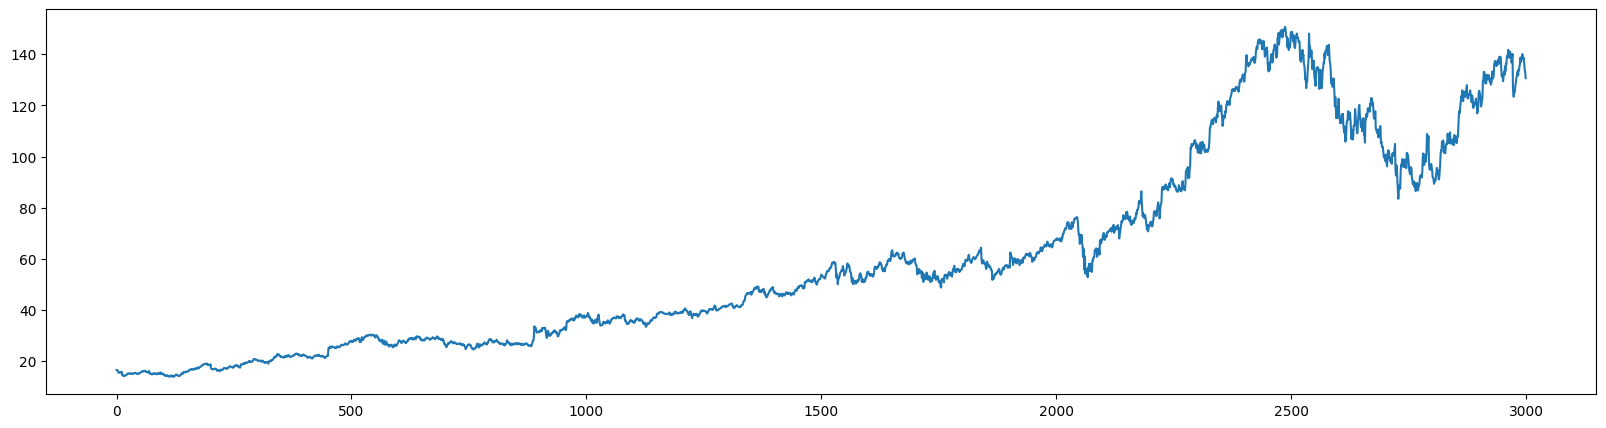

In [ ]:
# 그래프 생성 (20*5)
plt.figure(figsize=(20,5))
# x축은 인덱스에 해당하는 값 'Date', y축은 타겟인 'Close'로 지정
plt.plot(range(len(alphabet)), alphabet["Close"])

In [ ]:
# 학습과 검증 데이터셋을 시간으로 나눔 7월 31일 이전, 8월 1일 이후로 분리
target = 'Close'
train_start_date = start_date
train_end_date = '2023-7-31'
test_start_date = '2023-8-01'
training_set = alphabet[train_start_date:train_end_date].iloc[:,3:4].values
test_set = alphabet[test_start_date:].iloc[:,3:4].values
test_set_return = alphabet[test_start_date:].iloc[:,3:4].pct_change().values

print(training_set.shape)
print(test_set.shape)

(2912, 1)
(88, 1)


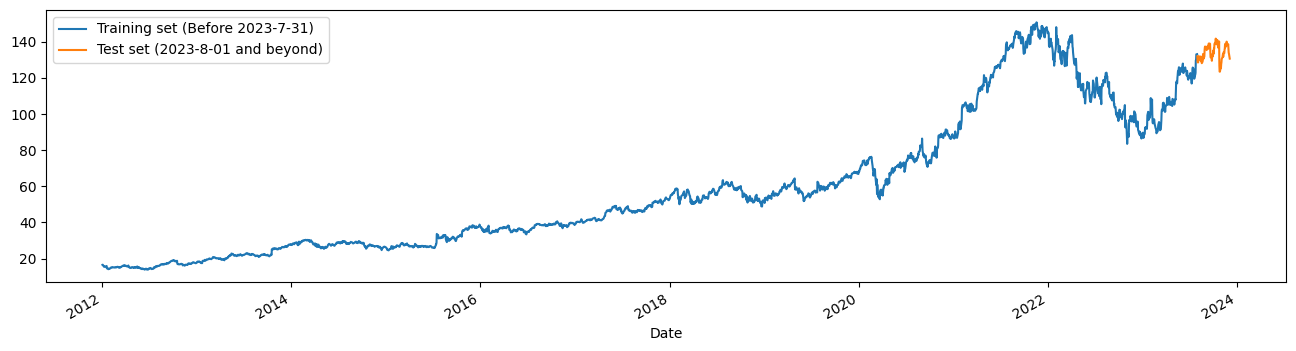

In [ ]:
# 분리 데이터셋 시각화
alphabet[target][train_start_date:train_end_date].plot(figsize=(16,4),legend=True)
alphabet[target][test_start_date:].plot(figsize=(16,4),legend=True)
plt.legend([f'Training set (Before {train_end_date})',f'Test set ({test_start_date} and beyond)'])
plt.show()

In [ ]:
# 정규화 진행
sc = MinMaxScaler(feature_range=(0,1))

training_set_scaled = sc.fit_transform(training_set)

In [ ]:
# 8개의 과거데이터를 기반으로 다음 시퀸스의 출력을 예측하기 위해 리스트 사용

timesteps = 8 # 과거데이터 사용 개수
# x_train, y_train 초기화
x_train = []
y_train = []

for i in range(timesteps,training_set.shape[0]):
    x_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train[0], y_train[0])
print(x_train[1], y_train[1])

[0.01936668 0.01988927 0.01820133 0.01656439 0.01154608 0.0116699
 0.01218339 0.01285346] 0.01200676380128074
[0.01988927 0.01820133 0.01656439 0.01154608 0.0116699  0.01218339
 0.01285346 0.01200676] 0.012660451232713046


In [ ]:
# 데이터 형식 변경 (배치 크기, 시퀀스 길이, 임베딩 차원)
print(x_train.shape, y_train.shape)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape, y_train.shape)

(2904, 8) (2904,)
(2904, 8, 1) (2904,)


In [ ]:
# 학습데이터를 무작위(random)로 섞음
print(x_train.shape, y_train.shape)
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

(2904, 8, 1) (2904,)


### 모델 구성 함수 선언


In [ ]:
# 인코더 레이어 구성
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):

    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
# 트랜스포머 기반의 모델을 구성하는 함수
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs, outputs)

In [ ]:
# 학습률 스케줄링 함수 정의
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

In [ ]:
# 학습 중 성능이 향상하지 않으면 종료, 학습률 조정
callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]

In [ ]:
input_shape = x_train.shape[1:]
print(input_shape)

(8, 1)


### 모델 생성

In [ ]:
x_train

array([[[0.56329256],
        [0.56295261],
        [0.55037081],
        ...,
        [0.54157233],
        [0.54439061],
        [0.54264704]],

       [[0.29270724],
        [0.29139861],
        [0.28579126],
        ...,
        [0.30742375],
        [0.31465775],
        [0.31479301]],

       [[0.02295015],
        [0.0222127 ],
        [0.02215442],
        ...,
        [0.02580525],
        [0.02424295],
        [0.02400442]],

       ...,

       [[0.91575463],
        [0.92211862],
        [0.91328361],
        ...,
        [0.93203201],
        [0.93395474],
        [0.94335265]],

       [[0.66013073],
        [0.67504466],
        [0.67358247],
        ...,
        [0.6431698 ],
        [0.63892955],
        [0.65852235]],

       [[0.71837541],
        [0.71291432],
        [0.72261565],
        ...,
        [0.73674732],
        [0.739233  ],
        [0.69039721]]])

In [ ]:
y_train

array([0.53712739, 0.31377681, 0.02676485, ..., 0.94965094, 0.66517516,
       0.68930059])

In [ ]:
# Transformer 설치
!pip install tensorflow -q # 트랜스포머를 구동하기위해 텐서플로우를 설치

In [ ]:
import tensorflow as tf

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
# 모델생성
model = build_model(
    input_shape,
    head_size=46,
    num_heads=60,
    ff_dim=55,
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)
# 모델 컴파일
model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"],
)
# 모델 학습
history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=20,
    callbacks=callbacks,
)

Epoch 1/100
117/117 [==============================] - 41s 273ms/step - loss: 0.2990 - mean_squared_error: 0.2990 - val_loss: 0.2941 - val_mean_squared_error: 0.2941 - lr: 1.0000e-06
Epoch 2/100
117/117 [==============================] - 27s 233ms/step - loss: 0.1757 - mean_squared_error: 0.1757 - val_loss: 0.1427 - val_mean_squared_error: 0.1427 - lr: 3.4300e-05
Epoch 3/100
117/117 [==============================] - 18s 157ms/step - loss: 0.0672 - mean_squared_error: 0.0672 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - lr: 6.7600e-05
Epoch 4/100
117/117 [==============================] - 16s 140ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 6.9479e-04 - val_mean_squared_error: 6.9479e-04 - lr: 1.0090e-04
Epoch 5/100
117/117 [==============================] - 16s 135ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 2.7932e-04 - val_mean_squared_error: 2.7932e-04 - lr: 1.3420e-04
Epoch 6/100
117/117 [==============================] - 16s 138ms/step

In [ ]:
# 3개 매개변수를 받아서 실제 가격과 예측가격을 나타내는 선 그래프 생성
def plot_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} Stock Price')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} Stock Price')
    plt.title(f'{symbol} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price')
    plt.legend()
    plt.show()
# 주식 가격의 수익율 출력
def plot_return_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} Stock Price Returns')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} Stock Price Return')
    plt.title(f'{symbol} Stock Return Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price Returns')
    plt.legend()
    plt.show()
# 평균 제곱근 오차 계산
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse
# 과거 데이터 딕셔너리를 반환
def get_ticker_data(ticker: str, param_start_date, param_end_date) -> dict:
    raw_data = YahooFinancials(ticker)
    return raw_data.get_historical_price_data(param_start_date, param_end_date, "daily").copy()
# 날짜, 시가, 고가, 저가, 조정 종가 및 거래량과 같은 관련 컬럼이 있는 DataFrame을 반환
def fetch_ticker_data(ticker: str, start_date, end_date) -> pd.DataFrame:
    date_range = pd.bdate_range(start=start_date, end=end_date)
    values = pd.DataFrame({'Date': date_range})
    values['Date'] = pd.to_datetime(values['Date'])
    raw_data = get_ticker_data(ticker, start_date, end_date)
    return pd.DataFrame(raw_data[ticker]["prices"])[['date', 'open', 'high', 'low', 'adjclose', 'volume']]
# 양수 n 값은 요소를 오른쪽으로 이동시키고(시간의 흐름을 따라), 음수 값은 요소를 왼쪽으로 이동
def shift(xs, n):
    e = np.empty_like(xs)
    if n >= 0:
        e[:n] = np.nan
        e[n:] = xs[:-n]
    else:
        e[n:] = np.nan
        e[:n] = xs[-n:]
    return e

3/3 [==============================] - 1s 67ms/step
[133.91999817] [133.32000732] [130.63000488]
[136.3999939] [133.91999817] [133.32000732]
[134.16801]


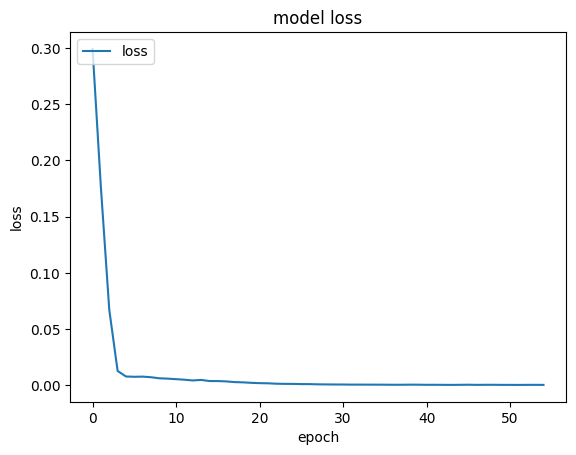

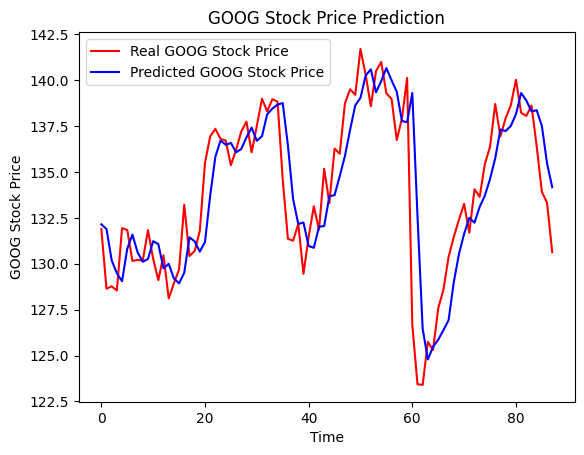

The root mean squared error is 2.529167433626253.


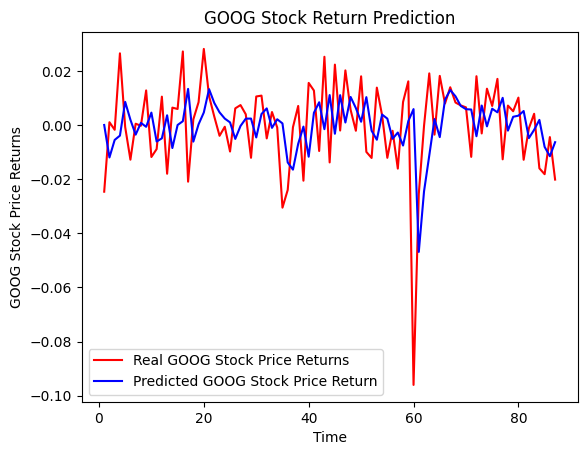

The root mean squared error is 0.018743190807512137.


0.018743190807512137

In [ ]:
# 데이터 전처리
original_symbol = "GOOG"
dataset_total = pd.concat((alphabet[target][:train_end_date],alphabet[target][test_start_date:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - timesteps:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.fit_transform(inputs)
# 테스트 데이터 준비
X_test = []
for i in range(timesteps,test_set.shape[0] + timesteps):
    X_test.append(inputs[i-timesteps:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# 테스트 결과 및 오차 확인
print(test_set[-3],test_set[-2], test_set[-1])
shifted_test_set = shift(test_set, 1)
print(shifted_test_set[-3],shifted_test_set[-2], shifted_test_set[-1])

print(predicted_stock_price[-1])
prediction_error = test_set - predicted_stock_price
predicted_return = (shifted_test_set - predicted_stock_price) / shifted_test_set
# 모델 손실 그래프
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()
# 주가 예측 결과 시각화 및 평가
plot_predictions(test_set,predicted_stock_price,original_symbol)
return_rmse(test_set,predicted_stock_price)
# 수익률 예측 결과 시각화 및 평가
plot_return_predictions(test_set_return,predicted_return,original_symbol)
return_rmse(test_set_return[1:], predicted_return[1:])

### 성능지표 데이터 저장

In [ ]:
# Mean Squared Error (MSE)
Tmse = mean_squared_error(test_set, predicted_stock_price)
print("Mean Squared Error (MSE):", Tmse)

# Mean Absolute Error (MAE)
Tmae = mean_absolute_error(test_set, predicted_stock_price)
print("Mean Absolute Error (MAE):", Tmae)

# Root Mean Squared Error (RMSE)
Trmse = np.sqrt(Tmse)
print("Root Mean Squared Error (RMSE):", Trmse)

# Mean Absolute Percentage Error (MAPE)
epsilon = 1e-10  # 작은 epsilon 값
Tmape = np.mean(np.abs((test_set - predicted_stock_price) / (test_set + epsilon))) * 100
print("Mean Absolute Percentage Error (MAPE):", Tmape)

Mean Squared Error (MSE): 6.396687907315606
Mean Absolute Error (MAE): 1.7592730955644087
Root Mean Squared Error (RMSE): 2.529167433626253
Mean Absolute Percentage Error (MAPE): 1.3270639192796176


In [ ]:
# performance_data 리스트 초기화
performance_data = []

# 두 번째 모델(Prophet)의 평가 지표 추가
performance_data = ['Transformer', Tmse, Tmae, Trmse, Tmape]

# 데이터프레임에 두 번째 행 추가
performance_df = performance_df.append(pd.DataFrame([performance_data], columns=['Model', 'MSE', 'MAE', 'RMSE', 'MAPE']), ignore_index=True)

# 데이터프레임 출력
print(performance_df)

WARNING - (py.warnings._showwarnmsg) - <ipython-input-68-24d36781fdd7>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_df = performance_df.append(pd.DataFrame([performance_data], columns=['Model', 'MSE', 'MAE', 'RMSE', 'MAPE']), ignore_index=True)

  performance_df = performance_df.append(pd.DataFrame([performance_data], columns=['Model', 'MSE', 'MAE', 'RMSE', 'MAPE']), ignore_index=True)



         Model            MSE           MAE          RMSE         MAPE
0        Arima  6.570543e+120  4.513391e+59  2.563307e+60  2338.036585
1  Transformer   6.396688e+00  1.759273e+00  2.529167e+00     1.327064


In [ ]:
# performance_data 리스트 초기화
performance_data = []

# 두 번째 모델(Prophet)의 평가 지표 추가
performance_data = ['Prophet', pmse, pmae, prmse, pmape]

# 데이터프레임에 두 번째 행 추가
performance_df = performance_df.append(pd.DataFrame([performance_data], columns=['Model', 'MSE', 'MAE', 'RMSE', 'MAPE']), ignore_index=True)

# 데이터프레임 출력
print(performance_df)

WARNING - (py.warnings._showwarnmsg) - <ipython-input-69-f2e18cb39ff0>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_df = performance_df.append(pd.DataFrame([performance_data], columns=['Model', 'MSE', 'MAE', 'RMSE', 'MAPE']), ignore_index=True)

  performance_df = performance_df.append(pd.DataFrame([performance_data], columns=['Model', 'MSE', 'MAE', 'RMSE', 'MAPE']), ignore_index=True)



         Model            MSE           MAE          RMSE           MAPE
0        Arima  6.570543e+120  4.513391e+59  2.563307e+60    2338.036585
1  Transformer   6.396688e+00  1.759273e+00  2.529167e+00       1.327064
2      Prophet   1.704041e-04  9.562110e-03  1.305389e-02  687198.420615


##Neural Prophet 모델 사용 주가예측


### 데이터 셋 가공

In [ ]:
alphabet = yf.download(symbol, start=start_date, end=end_date)
print("<Alphabet Inc. (GOOG) 주가 Historical Data>\n")
print(alphabet)

[*********************100%%**********************]  1 of 1 completed
<Alphabet Inc. (GOOG) 주가 Historical Data>

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2012-01-03   16.262545   16.641375   16.248346   16.573130   16.573130   
2012-01-04   16.563665   16.693678   16.453827   16.644611   16.644611   
2012-01-05   16.491436   16.537264   16.344486   16.413727   16.413727   
2012-01-06   16.417213   16.438385   16.184088   16.189817   16.189817   
2012-01-09   16.102144   16.114599   15.472754   15.503389   15.503389   
...                ...         ...         ...         ...         ...   
2023-11-28  137.630005  138.660004  137.039993  138.619995  138.619995   
2023-11-29  138.985001  139.669998  136.294998  136.399994  136.399994   
2023-11-30  136.399994  136.960007  132.789993  133.919998  133.919998   
2023-12-01  133.320007  133.500000  132.151993  133.320007  133.320007   


In [ ]:
# 인덱스는 사용할 수 없어서 칼럼으로 변경
alphabet.reset_index(inplace=True)
alphabet.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,16.262545,16.641375,16.248346,16.573130,16.573130,147611217
1,2012-01-04,16.563665,16.693678,16.453827,16.644611,16.644611,114989399
2,2012-01-05,16.491436,16.537264,16.344486,16.413727,16.413727,131808205
3,2012-01-06,16.417213,16.438385,16.184088,16.189817,16.189817,108119746
4,2012-01-09,16.102144,16.114599,15.472754,15.503389,15.503389,233776981


In [ ]:
#시계열 및 종속변수 이름 변경
data = alphabet.rename(columns={"Date":"ds","Close":"y"})
data.head()

,ds,Open,High,Low,y,Adj Close,Volume
0,2012-01-03,16.262545,16.641375,16.248346,16.573130,16.573130,147611217
1,2012-01-04,16.563665,16.693678,16.453827,16.644611,16.644611,114989399
2,2012-01-05,16.491436,16.537264,16.344486,16.413727,16.413727,131808205
3,2012-01-06,16.417213,16.438385,16.184088,16.189817,16.189817,108119746
4,2012-01-09,16.102144,16.114599,15.472754,15.503389,15.503389,233776981


In [ ]:
#y와 y의 t-1시점 데이터만을 사용
df = data.copy(deep=True)
df["l"]= np.append(0, data["y"].values[:-1])
df=df[['ds','y','l']]
df.tail(3)

,ds,y,l
2997,2023-11-30,133.919998,136.399994
2998,2023-12-01,133.320007,133.919998
2999,2023-12-04,130.630005,133.320007


### 모델 설정 및 학습

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

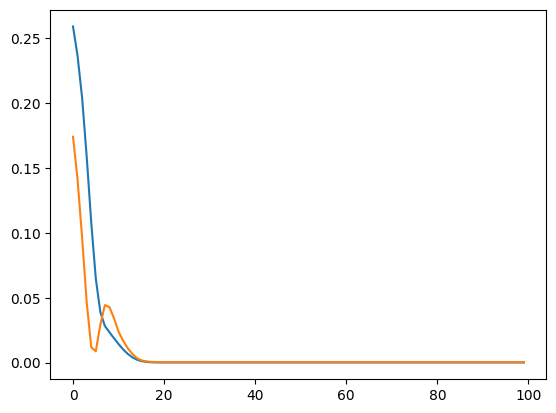

In [ ]:
# 모델 설정
m = NeuralProphet(
growth='off', # 추세 유형 설정(linear, discontinuous, off 중 선택 가능)
yearly_seasonality=False, #년간 계절성 설정
weekly_seasonality=False, #주간 계절성 설정
daily_seasonality=False, #일간 계절성 설정
batch_size=64,#배치 사이즈 설정
epochs=100,#학습 횟수 설정
learning_rate=0.05, # 학습률 설정
)

#독립 변인(변수) 추가 및 정규화
m = m.add_lagged_regressor(names=["l"], normalize="minmax")

#학습데이터, 검증데이터 분리
train, test = m.split_df(df, freq='B', valid_p = 0.10)

#학습 수행
metrics = m.fit(train, freq='B', validation_df=test, progress='plot')

In [ ]:
metrics.tail(3)

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,MAE,RMSE,Loss,RegLoss
97,2.499931,3.357863,0.000375,0.0,97,0.947959,1.559263,0.000081,0.0
98,2.499914,3.357850,0.000375,0.0,98,0.949876,1.587160,0.000081,0.0
99,2.499834,3.357801,0.000375,0.0,99,0.945094,1.568017,0.000080,0.0


In [ ]:
#metric 확인
print("MAE(Train): ", metrics.MAE.tail(1).item())
print("MAE(Test): ", metrics.MAE_val.tail(1).item())

MAE(Train):  0.945094108581543
MAE(Test):  2.499833583831787


In [ ]:
#학습 선 그래프 생성
px.line(metrics, y=['MAE', 'MAE_val'], width=800, height=400).show()

In [ ]:
#yhat1과 실제값 시각화(lag 데이터 포함x)
forecast = m.predict(test)
fig = m.plot(forecast[['ds', 'y', 'yhat1']]).show()

Predicting: 43it [00:00, ?it/s]

In [ ]:
#yhat1과 실제값 시각화(lag 데이터 포함O)
forecast = m.predict(test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast).show()

Predicting: 43it [00:00, ?it/s]

In [ ]:
#yhat1과 실제값 시각화(lag 데이터 포함O)
forecast = m.predict(test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast).show()

Predicting: 43it [00:00, ?it/s]

In [ ]:
#1-ahead에 대한 변수별 components 시각화
fig_comp = m.plot_components(forecast).show()

In [ ]:
print(metrics)

      MAE_val   RMSE_val  Loss_val  RegLoss_val  epoch         MAE  \
0   71.738983  72.315834  0.174128          0.0      0  103.866287   
1   64.410492  65.116074  0.141182          0.0      1   99.272903   
2   52.737667  53.728184  0.096119          0.0      2   92.064888   
3   35.681538  37.427910  0.046644          0.0      3   80.920555   
4   15.267871  18.872759  0.011860          0.0      4   65.695702   
..        ...        ...       ...          ...    ...         ...   
95   2.498865   3.357225  0.000375          0.0     95    0.958324   
96   2.499688   3.357729  0.000375          0.0     96    0.957346   
97   2.499931   3.357863  0.000375          0.0     97    0.947959   
98   2.499914   3.357850  0.000375          0.0     98    0.949876   
99   2.499834   3.357801  0.000375          0.0     99    0.945094   

          RMSE      Loss  RegLoss  
0   105.381439  0.259132      0.0  
1   101.004486  0.236473      0.0  
2    94.177254  0.203954      0.0  
3    83.798721 

### 성능지표 데이터 저장

In [ ]:
# 학습 성능
# MAE_val 출력
print("MAE(train): ", metrics.MAE.tail(1).item())
# RMSE_val 출력
print("RMSE(train): ", metrics.RMSE.tail(1).item())

# 테스트 성능
# MAE_val 출력
print("MAE_val(test): ", metrics.MAE_val.tail(1).item())
# RMSE_val 출력
print("RMSE_val(test): ", metrics.RMSE_val.tail(1).item())

NPmse = "Nan"
NPmae = metrics.MAE_val.tail(1).item()
NPrmse = metrics.RMSE_val.tail(1).item()
NPmape = "Nan"

MAE(train):  0.945094108581543
RMSE(train):  1.568016529083252
MAE_val(test):  2.499833583831787
RMSE_val(test):  3.3578009605407715


In [ ]:
# performance_data 리스트 초기화
performance_data = []

performance_data = ['Neural Prophet', NPmse, NPmae, NPrmse, NPmape]

# 데이터프레임에 두 번째 행 추가
performance_df = performance_df.append(pd.DataFrame([performance_data], columns=['Model', 'MSE', 'MAE', 'RMSE', 'MAPE']), ignore_index=True)

# 데이터프레임 출력
print(performance_df)

WARNING - (py.warnings._showwarnmsg) - <ipython-input-84-e6993d3ffd6b>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.




            Model                                                MSE  \
0           Arima  6570543230947339610762427680846299382740819889...   
1     Transformer                                           6.396688   
2         Prophet                                            0.00017   
3  Neural Prophet                                                Nan   

            MAE          RMSE           MAPE  
0  4.513391e+59  2.563307e+60    2338.036585  
1  1.759273e+00  2.529167e+00       1.327064  
2  9.562110e-03  1.305389e-02  687198.420615  
3  2.499834e+00  3.357801e+00            Nan  


## LSTM 모델 사용 주가예측

### 데이터 셋 가공 및 분석

In [ ]:
alphabet = yf.download(symbol, start=start_date, end=end_date)
print("<Alphabet Inc. (GOOG) 주가 Historical Data>\n")
print(alphabet)

[*********************100%%**********************]  1 of 1 completed
<Alphabet Inc. (GOOG) 주가 Historical Data>

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2012-01-03   16.262545   16.641375   16.248346   16.573130   16.573130   
2012-01-04   16.563665   16.693678   16.453827   16.644611   16.644611   
2012-01-05   16.491436   16.537264   16.344486   16.413727   16.413727   
2012-01-06   16.417213   16.438385   16.184088   16.189817   16.189817   
2012-01-09   16.102144   16.114599   15.472754   15.503389   15.503389   
...                ...         ...         ...         ...         ...   
2023-11-28  137.630005  138.660004  137.039993  138.619995  138.619995   
2023-11-29  138.985001  139.669998  136.294998  136.399994  136.399994   
2023-11-30  136.399994  136.960007  132.789993  133.919998  133.919998   
2023-12-01  133.320007  133.500000  132.151993  133.320007  133.320007   


In [ ]:
ran.seed(0)
np.random.seed(0)
tf.random.set_seed(0)
sns.set_style('dark')

In [ ]:
df = alphabet
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,16.262545,16.641375,16.248346,16.573130,16.573130,147611217
2012-01-04,16.563665,16.693678,16.453827,16.644611,16.644611,114989399
2012-01-05,16.491436,16.537264,16.344486,16.413727,16.413727,131808205
2012-01-06,16.417213,16.438385,16.184088,16.189817,16.189817,108119746
2012-01-09,16.102144,16.114599,15.472754,15.503389,15.503389,233776981
...,...,...,...,...,...,...
2023-11-28,137.630005,138.660004,137.039993,138.619995,138.619995,17046900
2023-11-29,138.985001,139.669998,136.294998,136.399994,136.399994,21014700
2023-11-30,136.399994,136.960007,132.789993,133.919998,133.919998,29913500


In [ ]:
# 결측치 제거
df = df.dropna()
# 중복행 제거
df=df.drop_duplicates()
# 칼럼 확인
df.columns.values

array(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'],
      dtype=object)

In [ ]:
# 인덱스 지정
df.reset_index(drop=True,inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
0,16.262545,16.641375,16.248346,16.573130,16.573130,147611217
1,16.563665,16.693678,16.453827,16.644611,16.644611,114989399
2,16.491436,16.537264,16.344486,16.413727,16.413727,131808205
3,16.417213,16.438385,16.184088,16.189817,16.189817,108119746
4,16.102144,16.114599,15.472754,15.503389,15.503389,233776981
...,...,...,...,...,...,...
2995,137.630005,138.660004,137.039993,138.619995,138.619995,17046900
2996,138.985001,139.669998,136.294998,136.399994,136.399994,21014700
2997,136.399994,136.960007,132.789993,133.919998,133.919998,29913500
2998,133.320007,133.500000,132.151993,133.320007,133.320007,24258400


In [ ]:
# 훈련 데이터와 테스트 데이터 분할
train = df[:int(0.90 * len(df))]
print("train",train)

test = df.iloc[2700:,:]
print("test",test)

train             Open        High         Low       Close   Adj Close     Volume
0      16.262545   16.641375   16.248346   16.573130   16.573130  147611217
1      16.563665   16.693678   16.453827   16.644611   16.644611  114989399
2      16.491436   16.537264   16.344486   16.413727   16.413727  131808205
3      16.417213   16.438385   16.184088   16.189817   16.189817  108119746
4      16.102144   16.114599   15.472754   15.503389   15.503389  233776981
...          ...         ...         ...         ...         ...        ...
2695  102.540001  104.019997  102.370003  103.849998  103.849998   19738600
2696  102.879997  103.169998  101.120003  101.830002  101.830002   24001700
2697  102.239998  103.489998   99.989998  100.010002  100.010002   26596800
2698   99.449997  101.680000   99.410004  100.570000  100.570000   21272700
2699  100.059998  100.110001   98.010002   99.169998   99.169998   25657000

[2700 rows x 6 columns]
test             Open        High         Low       Close

array([[<Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'High'}>],
       [<Axes: title={'center': 'Low'}>,
        <Axes: title={'center': 'Close'}>],
       [<Axes: title={'center': 'Adj Close'}>,
        <Axes: title={'center': 'Volume'}>]], dtype=object)

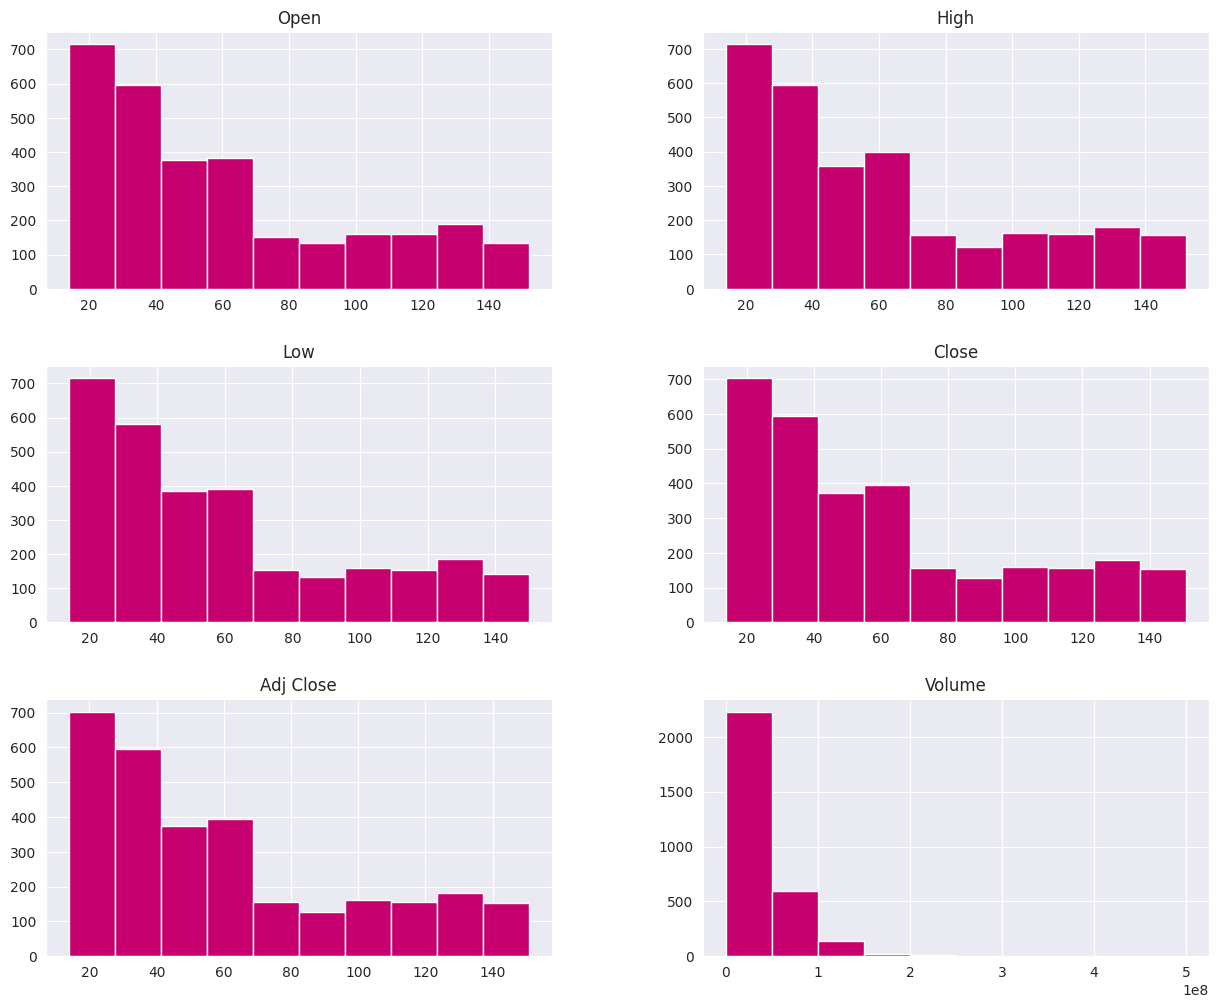

In [ ]:
# 칼럼별 변화를 확인하기 위해 시각화
df.hist(figsize=(15,12),color='#c6006e')

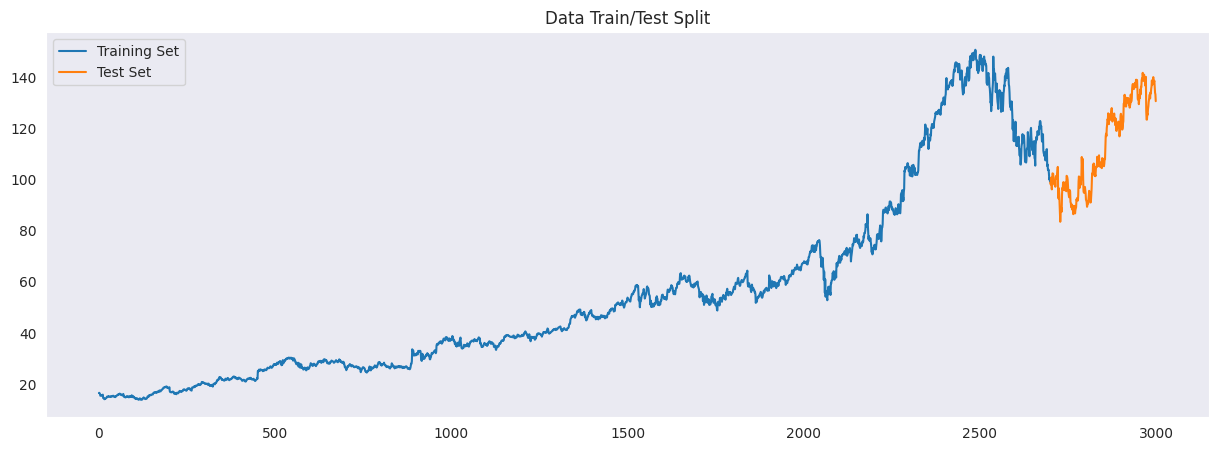

In [ ]:
# 학습 데이터와 검증 데이터 분리 확인
fig, ax = plt.subplots(figsize=(15, 5))
train.Close.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.Close.plot(ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])
plt.show();

In [ ]:
# 학습데이터의 종가 확인 및 변환
close_train= train.iloc[:, 4:5].values
close_train

array([[ 16.57312965],
       [ 16.64461136],
       [ 16.41372681],
       ...,
       [100.01000214],
       [100.56999969],
       [ 99.16999817]])

In [ ]:
# 학습데이터 일반화
normalizer = MinMaxScaler(feature_range=(-1,1))
train_set_scaled= normalizer.fit_transform(close_train)

In [ ]:
# 일반화 학습데이터 확인
train_set_scaled

array([[-0.96126663],
       [-0.96022146],
       [-0.96359734],
       ...,
       [ 0.25870498],
       [ 0.26689298],
       [ 0.24642287]])

In [ ]:
# 데이터 전처리
x_train= []
y_train = []

for i in range(60, len(train)):
    x_train.append(train_set_scaled[i-60:i, 0])
    y_train.append(train_set_scaled[i, 0])

x_train, y_train= np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### 모델 정의 및 학습

In [ ]:
# 모델 정의 및 학습
regressor = Sequential()

regressor.add(LSTM(units = 256, return_sequences = True, input_shape = (x_train.shape[1], 1)))
regressor.add(Dropout(0.1))


regressor.add(LSTM(units = 128, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.1))


regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.1))




regressor.add(Dense(units = 1, activation = 'selu'))
regressor.compile(optimizer = 'nadam', loss = 'mean_squared_error',metrics = ['mean_absolute_error'])


regressor.fit(x_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
83/83 [==============================] - 36s 340ms/step - loss: 0.0168 - mean_absolute_error: 0.0753
Epoch 2/100
83/83 [==============================] - 26s 311ms/step - loss: 0.0041 - mean_absolute_error: 0.0468
Epoch 3/100
83/83 [==============================] - 31s 375ms/step - loss: 0.0038 - mean_absolute_error: 0.0451
Epoch 4/100
83/83 [==============================] - 27s 318ms/step - loss: 0.0034 - mean_absolute_error: 0.0427
Epoch 5/100
83/83 [==============================] - 27s 332ms/step - loss: 0.0031 - mean_absolute_error: 0.0412
Epoch 6/100
83/83 [==============================] - 27s 330ms/step - loss: 0.0028 - mean_absolute_error: 0.0400
Epoch 7/100
83/83 [==============================] - 28s 332ms/step - loss: 0.0029 - mean_absolute_error: 0.0399
Epoch 8/100
83/83 [==============================] - 27s 331ms/step - loss: 0.0026 - mean_absolute_error: 0.0383
Epoch 9/100
83/83 [==============================] - 26s 309ms/step - loss: 0.0026 - mean_absolu

In [ ]:
# 테스트 데이터에서 종가 부분 추출
price_test = test.iloc[:, 4:5].values

In [ ]:
# 학습 데이터 형태 확인
close_train.shape

(2700, 1)

In [ ]:
# 학습데이터와 테스트데이터 종합 데이터프레임 생성
totality = pd.concat((pd.DataFrame(close_train), test['Close']), axis = 0)
totality.reset_index(drop=True,inplace=True)

In [ ]:
# 데이터 프레임 길이 확인
len(totality)

3000

In [ ]:
# 60일간의 데이터를 추출하여 입력데이터 구성
inputs = totality[len(totality) - len(test) - 60:].values
inputs = inputs.reshape(-1, 1)

In [ ]:
# 정규화
inputs = normalizer.transform(inputs)
len(inputs)

360

In [ ]:
# 테스트 데이터 데이터프레임 생성
x_test = []
y_test=[]
for i in range(60, len(inputs)):
    x_test.append(inputs[i-60:i, 0])


    y_test.append(inputs[i, 0])

x_test, y_test= np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
# 테스트 데이터 프레임 크기 확인
print('X_train Shape: ', x_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', x_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2640, 60, 1)
y_train Shape:  (2640,)
X_test Shape:   (300, 60, 1)
y_test Shape:   (300,)


In [ ]:
# 60일 예측 진행
predicted_price= regressor.predict(x_test)
predicted_price = normalizer.inverse_transform(predicted_price)

10/10 [==============================] - 2s 100ms/step


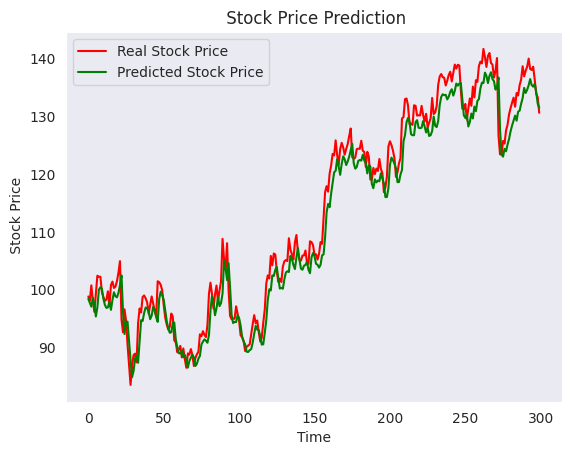

In [ ]:
# 시각화
plt.plot(price_test, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_price, color = 'green', label = 'Predicted Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [ ]:
r2_score(price_test[0:len(test)],predicted_price)

0.9658340307680906

In [ ]:
result =regressor.evaluate(x_test, y_test)

10/10 [==============================] - 3s 160ms/step - loss: 0.0022 - mean_absolute_error: 0.0377


### 성능지표 결과확인

In [ ]:
# regressor.evaluate를 호출하여 성능 지표를 얻음
evaluation_result = regressor.evaluate(x_test, y_test)

# 각 평가 지표에 대한 변수 할당
loss_value = evaluation_result[0]
mae_value = evaluation_result[1]

# 출력
print('MSE:', loss_value)
print('MAE:', mae_value)

10/10 [==============================] - 2s 152ms/step - loss: 0.0022 - mean_absolute_error: 0.0377
MSE: 0.002162340795621276
MAE: 0.037665821611881256


In [ ]:
# 모델에서 예측 수행
predictions = regressor.predict(x_test)

10/10 [==============================] - 1s 88ms/step


In [ ]:
# Mean Squared Error (MSE)
Lmse = loss_value
print("Mean Squared Error (MSE):", Lmse)

# Mean Absolute Error (MAE)
Lmae = mae_value
print("Mean Absolute Error (MAE):", Lmae)

# Root Mean Squared Error (RMSE)
Lrmse = np.sqrt(Lmse)
print("Root Mean Squared Error (RMSE):", Lrmse)

# Mean Absolute Percentage Error (MAPE)
mape_value = np.mean(np.abs((y_test - predictions) / np.abs(y_test))) * 100
print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape_value))

Mean Squared Error (MSE): 0.002162340795621276
Mean Absolute Error (MAE): 0.037665821611881256
Root Mean Squared Error (RMSE): 0.046500976286754196
Mean Absolute Percentage Error (MAPE): 106.63%


In [ ]:
# performance_data 리스트 초기화
performance_data = []
performance_data = ['LSTM', Lmse, Lmae, Lrmse, mape_value]
performance_df = performance_df.append(pd.DataFrame([performance_data], columns=['Model', 'MSE', 'MAE', 'RMSE', 'MAPE']), ignore_index=True)

# 데이터프레임 출력
print(performance_df)

WARNING - (py.warnings._showwarnmsg) - <ipython-input-113-9f6fbdfaf9d4>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.




            Model                                                MSE  \
0           Arima  6570543230947339610762427680846299382740819889...   
1     Transformer                                           6.396688   
2         Prophet                                            0.00017   
3  Neural Prophet                                                Nan   
4            LSTM                                           0.002162   

            MAE          RMSE           MAPE  
0  4.513391e+59  2.563307e+60    2338.036585  
1  1.759273e+00  2.529167e+00       1.327064  
2  9.562110e-03  1.305389e-02  687198.420615  
3  2.499834e+00  3.357801e+00            Nan  
4  3.766582e-02  4.650098e-02     106.626653  


## 정리

### ARIMA

참고 코드
https://velog.io/@isitcake_yes/mlarimastockprediction

특징
1. 다양한 패턴을 모델링 가능
2. 정상성을 가정하여 모델에 적용됨
3. 자기회귀모형 + 이동평균모형
4. 비정상성 데이터 전처리


장점
1. 간단한 구조
2. 시계열 데이터에 대한 이해 용이 (설명이 용이)


단점
1. 정상성 가정 (전처리가 필요함)
2. 하이퍼파라미터 설정 어려움


작성 중 느낀점
1. 사용이 간단하며 오토 아리마를 통해서 모델을 지정해서 생성가능
2. 설명을 할 수 있으며 시각화를 통해 직관적으로 확인 가능
3. 다른 모델보다 빠르게 생성할 수 있었고 확인이 가능했음
4. 참고할만한 코드가 많음
5. 오차가 매우 큼

### Prophet


참고코드 https://panggu15.github.io/sequence/prophet-%EC%A3%BC%EC%8B%9D-%EC%98%88%EC%B8%A1/

특징
1. 간단한 사용법
2. 계절성 처리
3. 휴일 효과 처리
4. 유연성
5. 트렌드 변화 감지

장점
1. 높은 수준의 추상화
2. 시간 복잡성 감소
3. 풍부한 기능

단점
1. 일반성
2. 성능한계
3. 맞춤성의 한계

작성 중 느낀점
1. 모델을 시각화해서 결과를 확인하면 실제 데이터의 트렌드만 보여줌
2. 예측값과 주가 데이터 그래프가 아예 다름
3. 타깃을 재설정하여 '변동'으로 맞춰줄 경우 예측과 실제 그래프가 비슷하게 나옴
4. 예측값과 실제 변동 그래프가 어느정도 비슷한 양상을 보임

### Transformer


참고코드 https://www.kaggle.com/code/fredblair/transformers-for-stocks

특징
1. 자연어 처리에 적합
2. 어텐션 매커니즘 사용
3. 인코더-디코더 구조
4. 사전 훈련 및 전이 학습

장점
1. 병렬 처리 가능
2. 장거리 의존성 처리
3. 다양한 입력 크기 처리
4. 캡슐화된 표현
5. 전이 학습 용이성

단점
1. 계산비용
2. 데이터 양에 대한 의존성
3. 해석의 어려움
4. 순서 정보 손실
5. 작은 데이터에 대한 성능 하락

작성 중 느낀점
1. 성능점수 확인이 어려움
2. 오차가 매우 빠르게 내려감 (학습 속도가 빠름, 오버피팅이 있을 수 있음)
3. 코드가 함수로 되어있어서 하나하나 이해하면서 쓰는데 시간이 걸림
4. 예측값이 실제값의 하한가, 상한가 중간에 항상 위치했음
5. 생각보다 예측 구조가 간단하였음. (데이터셋 불러오기 > 학습데이터 나누기 > 학습 > 결과 확인)

### NeuralProphet

참고코드
https://bigwaveai.tistory.com/27

특징
1. 시계열 예측의 기본요소를 모두 포함
2. 데이터에 대한 이해를 바탕으로 예측 수행
3. 효율적인 예측 수행(학습이 빠름)
4. Prophet의 확장

장점
1. 다양한 시계열 데이터에 적용가능
2. 높은 예측 정확도를 제공
3. 사용이 간단함

단점
1. 데이터에 대한 이해가 필요
2. 구현이 복잡합

작성 중 느낀점
1. 간단한 주식예측 코드를 찾기 힘들다.
2. 기존에 있는 에너리 예측 관련 코드를 참고하여 혼자 만들어보았다.
3. 전문화 되진 않는 모델을 생성하였으나 어느정도 성능은 나오는 것 같다.


###LSTM


참고코드 https://www.kaggle.com/code/rezasemyari/google-stock-accuracy-0-97-loss-0-002

특징
1. RNN의 단점인 기울기 소실의 문제 해결
2. 메모리셀을 사용하여 이전상태 정보 저장 및 장기 패턴 학습

장점
1. 장기적인 패턴 학습 용이
2. 기울기 소실 문제 해결

단점
1. 모델 구조가 복잡합
2. 계산 비용이 높음

구현 중 느낀점
1. 간단하고 노력대비 정확하게 예측을 함
2. 학습과 검증을 하기 전에 데이터 전처리가 필요함
3. 예제가 매우 많고 거의 비슷한 형식이 많음



## 결과

주제

구글(GOOG) 주식 예측을 위한 시계열 예측 모델 비교

목적

다양한 시계열 예측 모델의 성능을 비교하여 구글 주식 예측에 적합한 모델을 도출

연구방법

1. 야후 파이낸스에 있는 과거데이터를 가져온다.(12년 1월~ 23년 12월)
2. 5가지(ARIMA, Prophet, Transformer, NeuralProphet) 시계열 예측 모델을 확인해본다.
3. 예측 모델 5가지 확인 후 성능지표 (MAE, RMSE, MAPE) 추출
4. 성능지표를 통해 가장 적합한 모델을 지정


In [ ]:
# 데이터프레임 출력
print(performance_df)

            Model                                                MSE  \
0           Arima  6570543230947339610762427680846299382740819889...   
1     Transformer                                           6.396688   
2         Prophet                                            0.00017   
3  Neural Prophet                                                Nan   
4            LSTM                                           0.002162   

            MAE          RMSE           MAPE  
0  4.513391e+59  2.563307e+60    2338.036585  
1  1.759273e+00  2.529167e+00       1.327064  
2  9.562110e-03  1.305389e-02  687198.420615  
3  2.499834e+00  3.357801e+00            Nan  
4  3.766582e-02  4.650098e-02     106.626653  


In [ ]:
# 지수 표기법으로 출력하고 소수점은 5자리까지 나타냄
pd.set_option('display.float_format', '{:,.5e}'.format)

# 데이터프레임 출력
print(performance_df.round(5).to_string(index=False))


         Model          MSE         MAE        RMSE        MAPE
         Arima 6.57054e+120 4.51339e+59 2.56331e+60 2.33804e+03
   Transformer  6.39669e+00 1.75927e+00 2.52917e+00 1.32706e+00
       Prophet  1.70404e-04 9.56000e-03 1.30500e-02 6.87198e+05
Neural Prophet          Nan 2.49983e+00 3.35780e+00         Nan
          LSTM  2.16234e-03 3.76700e-02 4.65000e-02 1.06627e+02


성능 결과
1. Prophet
2. LSTM
3. NeuralProphet
4. Transformer
5. ARIMA

예상과는 달리 프로펫이 가장 점수가 좋았으며 ARIMA 가 점수로 봤을때 성능이 가장 많이 떨어지는 것으로 확인됩니다.

프로펫과 LSTM의 점수차이는 많이 나지 않지만 나머지가 두 모델(프로펫, LSTM)에 비해 점수차이가 많이 나게 결과가 확인되었습니다.

뉴럴 프로펫 구현과 트랜스포머 구현이 미흡하여 점수가 다른 모델에 비해 못 나온 것으로 생각됩니다.

구현 및 사용
1. LSTM
2. Prophet
3. ARIMA
4. Transformer
5. NeuralProphet

구현과 사용에서는 LSTM 과 Prophet이 예제와 간단한 구조 덕분에 만들기 쉬웠습니다.

트랜스포머와 뉴럴프로펫은 예제를 찾기 어려워서 다른 모델을 참고하여 작성하였고 전체적으로 만들기가 어려웠습니다.

전체 느낀점

5가지의 모델을 확인하였으나 모델 구현에서 정확히 하지 못하여 모든 모델의 점수가 SOTA가 아니므로 좀 더 정확히 구현하는 방법과 데이터 셋을 종가(또는 차이값)로만이 아닌 다른 지표가 필요할 것 같습니다.

작성자가 각각의 모델에 전체적인 특성을 잘 알지 못하여 진행하면서 알게 된 것 들 위주로 정리하였습니다.

모델의 예시가 없는 경우에는 다른 예측 모델 구현한 코드를 참고하여 작성하였습니다. (트랜스포머, NeuralProphet)

전체적으로 진행한 사항은 모델들을 돌려보고 비교하는 것이었으며 각 모델별 분석을 진행할 때 작성할 때 느낀점을 따로 작성하였습니다.

